# 1. Background

Convolutional Neural Networks (CNNs) are fundamental to brain imaging. They function by applying a series of convolutional operations to an image.

CNNs apply this filtering operation repeatedly in varying sizes and formats, allowing the model to gain an *understanding* of the image. However, the complexity of the model increases substantially with the addition of more filters, leading to intensive memory and computational demands due to the vast complexity and numerous parameters [1].

A layer known as Max Pooling is incorporated into these networks. This layer maintains the same depth of the model while reducing its spatial size, thereby enhancing computational efficiency. It also preserves the key features of an image [2]. Several other layers are similarly employed to manage computation by adjusting either the depth or spatial size of the model.

Likewise, another layer, called the convolutional layer, is the core building block of a CNN. The convolutional layer applies a set of learnable filters (or kernels) to the input image. Each filter slides over the input image, performing element-wise multiplication and summing the results to produce a feature map. This operation allows the network to detect various features such as edges, textures, and patterns in the image. The parameters of these filters are learned during the training process. 

It was however observed that some uncertainty propagates through the network using these techniques. For instance, assume the following 4x4 matrix:

$$
\begin{bmatrix}
7 & 7 \\
4 & 5
\end{bmatrix}
$$

A max pooling layer needs to choose which of the 7s to keep, and later, during upsampling, remember the index where the 7 was found. Different implementations or software stacks can cause different issues and contribute to numerical unstability.

# 2. Introduction

Observations from Dr. Glatard's lab suggest that replacing such occurrences with NaN values could potentially improve computational speed during both training and inference, while preserving the accuracy of the model. The logic is that parts of images with redundant information (e.g., the background) could be disregarded during the convolutional operation, as image patches containing a high count of NaN values might be ignored. Likewise, this will solve the problem mentioned above. This is hypothesized to accelerate the calculations in convolutional operations.

A Python implementation of this NaN pooling has already been developed with success in the lab, which showed promising results. However, to fully harness the potential of this approach, it must be adapted to PyTorch's C++ backend.

Hence, the following project is proposed: Can a C++ PyTorch implementation of this solution improve the speed of inference and training of CNN models and prevent uncertainty propagation while conserving current accuracy benchmarks?


# 3. Developping the Max Pooling inside C++
## 3.1 Approach 1: Re-writing the current NaN python implementation using Torch's C++ extension framework

Torch offers an elegant [solution](https://pytorch.org/tutorials/advanced/cpp_extension.html) to writing your own custom C++ extensions. In essence, including the following header ```#include <torch/extension.h>``` in your C++ code, and creating a python setup.py file allows you to use Torch's existing C++ frontend, as well as extending it. 

To do so, we first created the following build files:

---
Dockerfile:

```Dockerfile
Use the latest PyTorch base image with CUDA 12.1 and cuDNN 8
FROM pytorch/pytorch:2.2.1-cuda12.1-cudnn8-devel

# Install necessary dependencies
RUN apt-get update && apt-get install -y \
    build-essential \
    cmake \
    git \
    python3-dev \
    python3-pip \
    libpython3-dev \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements.txt and install Python dependencies
COPY requirements.txt /workspace/requirements.txt
WORKDIR /workspace

# Install Python dependencies
RUN pip install --upgrade pip && \
    pip install -r requirements.txt --no-cache-dir

# Copy files into workspace
COPY . /workspace

# Set the working directory
WORKDIR /workspace
```

---
docker-compose.yml
```yaml
services:
  pytorch_cpp_extension:
    image: pytorch_cpp_extension
    build:
      context: .
    volumes:
      - .:/workspace
    working_dir: /workspace
    entrypoint: /bin/bash -c "python setup.py build_ext --inplace && python setup.py install && /bin/bash"
```

--- 
setup.py 
```python
from setuptools import setup, Extension
from torch.utils import cpp_extension

setup(
    name='nan_cpp',
    ext_modules=[cpp_extension.CppExtension('nan_cpp', ['nan.cpp'], extra_compile_args=["-g"])],
    cmdclass={'build_ext': cpp_extension.BuildExtension}
)
```

---
Combined together, these three files allow the user to create the necessary environment to build their own extensions. Furthermore, the .yml file allows for automatic mounting. By calling 

```docker-compose run --rm pytorch_cpp_extension```

A docker image will be built and and the user will be automatically attached. This will also call the necessary commands to build, compile and link the C++ and python files.




**C++ Implementation**
Let's take a first stab at implementing python NaN Pooling based on the python version already built in the lab (code can be found in the file nan_ops.py [here](https://github.com/InesGP/fastsurfer-embeddings/blob/ines_embeddings/embedding_project/nan_ops.py)): 


```cpp
#include <torch/extension.h>
#include <optional>
#include <iostream>
#include <tuple>

// Struct to hold pooling attributes
struct PoolingAttributes {
    int batch_size;          // Number of samples in a batch
    int channels;            // Number of channels in the input tensor
    int input_height;        // Height of the input tensor
    int input_width;         // Width of the input tensor
    int pool_height;         // Height of the pooling window
    int pool_width;          // Width of the pooling window
    int stride_height;       // Height of the stride
    int stride_width;        // Width of the stride
    float threshold;         // Threshold to determine if a max value is ambiguous
    torch::Tensor input_tensor;  // The input tensor
    torch::Tensor output_tensor; // The output tensor for pooled values
    torch::Tensor index_tensor;  // The output tensor for pooled indices
};

// Function to check for NaNs in the pooling window and update the output tensors
std::tuple<torch::Tensor, torch::Tensor> check_for_nans(
    PoolingAttributes& attrs,
    torch::Tensor window, 
    torch::Tensor maxval, 
    torch::Tensor max_index,
    int c, 
    int i, 
    int j
) {
    // Convert 1D indices from the pooling window to 2D indices
    max_index = torch::stack({max_index / attrs.pool_height, max_index % attrs.pool_width}, 1);
    // If any of the max values are NaN, replace NaNs in the window with -infinity and recompute max values
    if (torch::isnan(maxval).any().item<bool>()) {
        window.masked_fill_(torch::isnan(window), -std::numeric_limits<float>::infinity());
        maxval = std::get<0>(torch::max(window.reshape({attrs.batch_size, -1}), 1));
    }
    
    
    // Check if multiple values are close to the max value
    auto reshaped_maxval = maxval.unsqueeze(1).unsqueeze(2);

    // Perform the isclose comparison with the specified rtol and equal_nan=True
    auto close_to_max = torch::isclose(window, reshaped_maxval, 1e-7, 1e-7, true);
    auto check_multi_max = torch::sum(close_to_max, {1, 2});
    

    // If the proportion of close values exceeds the threshold, set the max value to NaN
    if ((check_multi_max > attrs.threshold).any().item<bool>()) {
        auto nan_tensor = torch::full_like(maxval, std::numeric_limits<float>::quiet_NaN());
        maxval = torch::where(check_multi_max > attrs.threshold, nan_tensor, maxval);
    }

    // Type-casting to int
    max_index = max_index.toType(torch::kInt64);

    // Find new index of max value if it has changed and is not NaN
    // std::cout << "max_index: " << max_index << std::endl;
    auto non_zero_elems = torch::where(window == maxval)[0].numel();
    if (non_zero_elems != 0) {
        auto max_vals = torch::max(
            window.masked_fill(torch::isnan(window), -std::numeric_limits<float>::infinity()).view({attrs.batch_size, -1}), 1
        );
        max_index = std::get<1>(max_vals).toType(torch::kInt64);
        // std::cout << "max_index during: " << max_index << std::endl;
        max_index = torch::stack({max_index / attrs.pool_width, max_index % attrs.pool_width}, 1);
    }
    max_index = max_index.toType(torch::kInt64);
    // Convert the 2D indices back to 1D
    auto max_index_1d = 
        (i * attrs.stride_height + max_index.index({torch::indexing::Slice(), 0})) * attrs.input_width + 
        (j * attrs.stride_width + max_index.index({torch::indexing::Slice(), 1}));

    

    // Update the output tensors with the computed max values and indices
    attrs.output_tensor.index_put_({
        torch::indexing::Slice(), 
        c, 
        i, 
        j
        }, maxval.view({attrs.batch_size}));
    attrs.index_tensor.index_put_({
        torch::indexing::Slice(), 
        c, 
        i, 
        j}, max_index_1d.view({attrs.batch_size}));

    return std::make_tuple(attrs.output_tensor, attrs.index_tensor);
}

// Main function to perform NaN-aware max pooling
std::tuple<torch::Tensor, torch::Tensor> NaNPool2d(
    torch::Tensor input_tensor, 
    std::tuple<int, int> pool_size, 
    float threshold = 0.5, 
    std::optional<std::tuple<int, int>> strides = std::nullopt
) {
    // Extract the size of the input tensor
    auto size = input_tensor.sizes();
    PoolingAttributes attrs;
    attrs.batch_size = size[0];
    attrs.channels = size[1];
    attrs.input_height = size[2];
    attrs.input_width = size[3];

    // Unpack the pool size
    std::tie(attrs.pool_height, attrs.pool_width) = pool_size;

    // Unpack or set default strides
    if (strides) {
        std::tie(attrs.stride_height, attrs.stride_width) = strides.value();
    } else {
        std::tie(attrs.stride_height, attrs.stride_width) = pool_size;
    }

    // Set the threshold and input tensor
    attrs.threshold = threshold;
    attrs.input_tensor = input_tensor;

    // Calculate the output dimensions
    int output_height = (attrs.input_height - attrs.pool_height) / attrs.stride_height + 1;
    int output_width = (attrs.input_width - attrs.pool_width) / attrs.stride_width + 1;

    // Initialize the output tensors for pooled values and indices
    attrs.output_tensor = torch::zeros({attrs.batch_size, attrs.channels, output_height, output_width});
    attrs.index_tensor = torch::zeros({attrs.batch_size, attrs.channels, output_height, output_width}, torch::kInt64);

    // Perform max pooling with NaN handling
    for (int c = 0; c < attrs.channels; c++) {
        for (int i = 0; i < output_height; i++) {
            for (int j = 0; j < output_width; j++) {
                // Extract the current pooling window
                torch::Tensor window = attrs.input_tensor.index({
                    torch::indexing::Slice(),
                    c,
                    torch::indexing::Slice(i * attrs.stride_height, i * attrs.stride_height + attrs.pool_height),
                    torch::indexing::Slice(j * attrs.stride_width, j * attrs.stride_width + attrs.pool_width)
                });

                // Reshape the window for max pooling
                torch::Tensor reshaped_window = window.reshape({attrs.batch_size, -1});

                // Compute the max values and their indices in the window
                auto max_result = torch::max(reshaped_window, 1);
                auto max_values = std::get<0>(max_result);
                auto max_indices = std::get<1>(max_result);

                // Check for NaNs and update the output tensors
                std::tie(attrs.output_tensor, attrs.index_tensor) = check_for_nans(
                    attrs,
                    window, 
                    max_values, 
                    max_indices,
                    c, 
                    i, 
                    j
                );
            }
        }
    }

    return std::make_tuple(attrs.output_tensor, attrs.index_tensor);
}

// Bind the function to Python
PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("NaNPool2d", &NaNPool2d, "Create a NaN pooling layer. Returns a tuple of tensors.");
}
```
---


The implementation tries to follow the given Python logic 1:1.

Example sliding window example:
$
\begin{bmatrix}
7 & 7 \\
4 & NaN
\end{bmatrix}
$ &rarr;
$
\begin{bmatrix}
7 & 7 \\
4 & -inf
\end{bmatrix}
$ &rarr;
$
\begin{bmatrix}
NaN & NaN \\
4 & -inf
\end{bmatrix}
$


*Max Value*: NaN, *Returned Index*: 0

The algorithm works as follows:

---

*It follows the same mechanics as a regular pooling (i.e., a sliding window going over the input tensor. Pool size, stride, and other parameters have their regular definition).*

1. **Initialization**:
   - The class is initialized with an optional threshold value (`max_threshold`) that determines how to handle cases where multiple maximum values are found in the pooling window.

2. **Max Pooling with NaN Handling**:
   - The algorithm iterates over each channel of the input tensor and performs max pooling in a sliding window fashion.
   - For each window, it checks for NaN values and replaces them with negative infinity to ensure they are not considered in the max value computation.
   - It calculates the maximum value in the window.
   - If multiple maximum values are found that exceed the max duplicate values threshold, these max values are replaced with NaN.

3. **Index Conversion**:
   - Converts the max indices from 1D to 2D format for proper placement in the pooled output.

4. **Output and Index Arrays**:
   - Maintains arrays for storing the pooled values and their corresponding indices.
   - Updates these arrays with the computed max values and their indices for each window.


# 4. Comparison of results of NaNpool in python, NaNPool in Torch C++, PythonPool implementation and Torch Max Pool

In the following cells, we will be running and evaluating different forms of max pooling and comparing their results, both in terms of execution speed and viusal results. 

There are four implementations: 
1. NaNPool Python: The class defined above that handles NaNs\DuplicateMax according to custom written rules.
2. NaNPool C++: The same class but written in C++ using torch extensions
3. Normal Pool: Python implementation of Max Pooling that doesn't handle NaNs\DuplicateMax in any special ways.
4. TorchPool: Torch implementation of MaxPool

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import nan_cpp as nanCPP
import time
from nan_ops import NaNPool2d, NormalPool2d, NaNConv2d, NormalConv2d
FILENAME = "mri_data//sample_data//outp_bn3_1.pkl"
# Load the data from the pickle file
data = pickle.load(open(FILENAME, 'rb'))

if isinstance(data, tuple):
    a = data[0]
else:
    a = data

# Comparison of different pooling operations

First, we begin with a C++ implementation which can be found under nan.cpp. It converts the custom NaN pooling classes into C++, to hopefully improve the speed of execution of these files (or, in the very least, improve the speed of further convolutional layers). This was built following C++ frontent Torch libraries that are found [here](https://pytorch.org/cppdocs/frontend.html).

C++ Pooling

In [2]:
%%timeit -o -n 1 -r 10
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 1, None)


1min 37s ± 26.2 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 1min 37s ± 26.2 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [3]:
cppTime = _

In [4]:
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 1, (2,2))

Let's run the NaNPooling, python pooling, and torch pooling to compare speeds.

NaNPooling Pooling

In [5]:
%%timeit -o -n 1 -r 10
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


2min 23s ± 16.9 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 2min 23s ± 16.9 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [6]:
pyTime = _

In [18]:
nanpoolPy = NaNPool2d(max_threshold=1)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Normal Pool

In [8]:
%%timeit -o -n 1 -r 10
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


44 s ± 2.48 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 44 s ± 2.48 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [9]:
normalTime = _

In [10]:
normalpool = NormalPool2d(max_threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size

Torch Pool

In [11]:
%%timeit -o -n 1 -r 10
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

The slowest run took 6.90 times longer than the fastest. This could mean that an intermediate result is being cached.
4.45 ms ± 4.53 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


<TimeitResult : 4.45 ms ± 4.53 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

In [12]:
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)

In [13]:
torchTime = _

Visualizing the pooling

It's time to visualize the pooling. For reference here is the mapping between the different layers and their implementation. These are not quite meant as a full validation but rather as a sanity check to see if we're on the right track. Unit tests were perfomed to make sure different scenarios gave the same respones.
- nanCPP.NaNPool2d -> NaN aware pooling built in *C++*
- NaNPool2d -> NaN aware pooling built in *Python*
- NormalPool2d -> NaN **un**aware pooling built in *Python*
- torch.nn.MaxPool2d -> NaN **un**aware pooling built in *PyTorch*

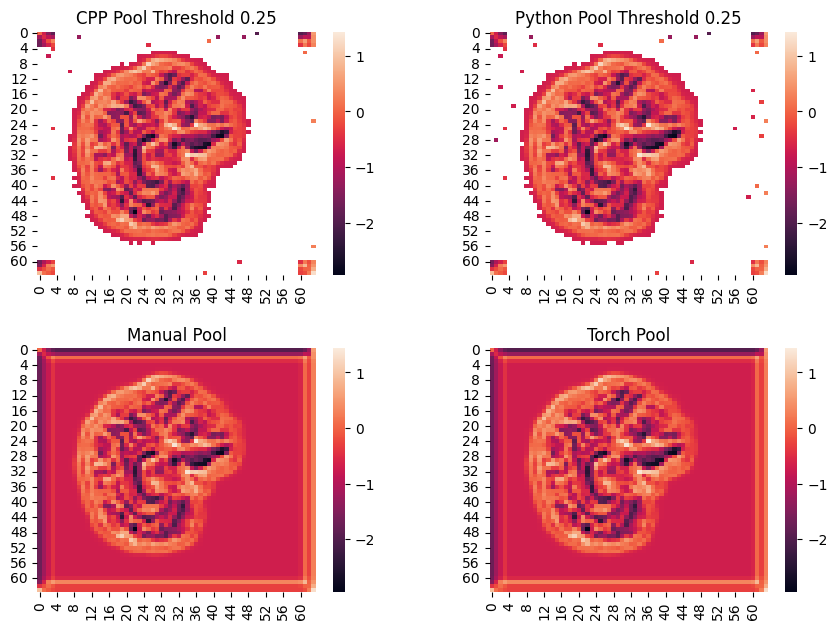

In [20]:
# Visualize output
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')
sns.heatmap(np.mean(nanoutputPy.detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')
sns.heatmap(np.mean(normaloutput.detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')
sns.heatmap(np.mean(torchoutput.detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Visualizing the difference between both

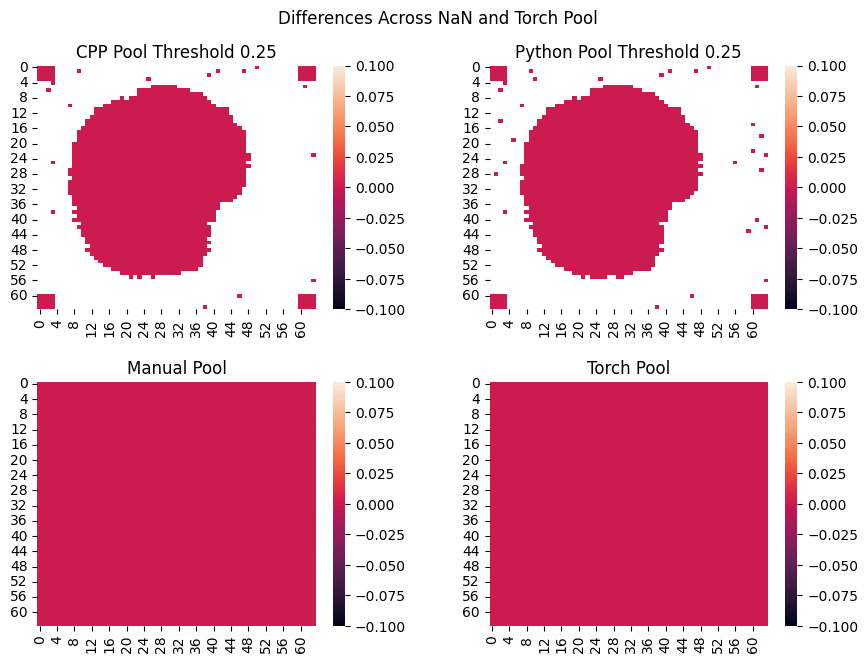

In [19]:
# %%timeit
# Visualize output differences -- should be 0
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Adjusted figure size for better layout

sns.heatmap(np.mean((nanoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')

sns.heatmap(np.mean((nanoutputPy - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')

sns.heatmap(np.mean((normaloutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')

sns.heatmap(np.mean((torchoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')

plt.suptitle('Differences Across NaN and Torch Pool')
# plt.savefig('/workspace/differences_comparison.png')  # Save the second plot
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

It can observed that the differences between both implementations (c++ and python) are very minimal. There are some small differences, mainly on the RHS of the image. However, C++ seems to ignore the background image a little better.



Exploring the time taken for each method

In [16]:
cpp_time = cppTime.average
py_time = pyTime.all_runs
normal_time = normalTime.all_runs
torch_time = torchTime.all_runs

cpp_time

97.62031910540027

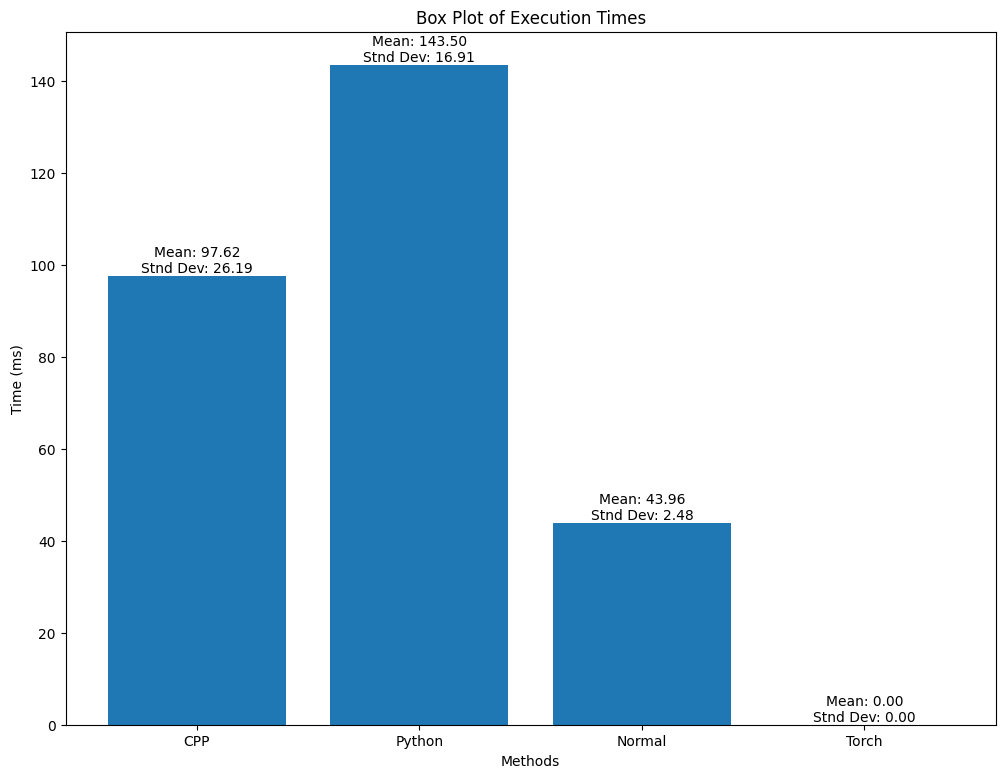

In [17]:
methods = ['CPP', 'Python', 'Normal', 'Torch']
times_objects = [cppTime, pyTime, normalTime, torchTime]

# Extracting the vectors from the time objects
cpp_time = cppTime.average
py_time = pyTime.average
normal_time = normalTime.average
torch_time = torchTime.average

# Extracting the standard deviations
cpp_std = cppTime.stdev
py_std = pyTime.stdev
normal_std = normalTime.stdev
torch_std = torchTime.stdev

times = [cpp_time, py_time, normal_time, torch_time]
times_stnd_dev = [cpp_std, py_std, normal_std, torch_std]

fig, ax = plt.subplots(figsize=(12, 9))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean, std_dev in zip(bars, times, times_stnd_dev):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}\nStnd Dev: {std_dev:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure

By observing the box plot, we notice a slight decrease in execution time between the Python and C++ implementations, as expected. Interestingly, the custom-written normal pooling method is faster than the NaN pooling method. This is expected because the computational speedup for NaN layers should be realized during the custom NaN convolution operation at the cost of a slower max pooling layer. NaNPooling involves additional comparisons to check for NaNs and duplicates, and to replace these values as necessary, which is not required in normal max pooling. However, during NaNConv, some convolutions should be skipped which should mean that we will see a faster execution time.

Given Torch's highly optimized code, matching its speed with our custom layers will be challenging. Notably, they can have different mathematical implementations (i.e., seperable filter, recursive convolution, using FFT) or simply parallelizing the convolution operation.

It can be observed that the improvement seen in our case reflect those found in pytorch's documentation found [here](https://pytorch.org/tutorials/advanced/cpp_extension.html). Their improvement takes about ~67% of the initial time whereas our takes about ~68% of our initial time. 

Documentation Example:
- Python custom implementation `Forward: 506.480 us | Backward 444.694 us`
- C++ custom implementation `Forward: 349.335 us | Backward 443.523 us`

NaN Pooling
- NaNPython custom implementation `NaNPooling: 143.50 sec`
- C++ custom implementation `NaNPooling: 97.62 sec`

# 5.0 Re-implementing in Torch Source

The observed disparity between the Torch source code and our custom implementation is too significant to overlook. Torch is exceptionally optimized, featuring custom MaxPooling functions tailored to the specific hardware executing the function, and is fine-tuned on a case-by-case basis. Consequently, recreating the custom implementations would be a monumental task. Instead of attempting to surpass its speed on our own, we will modify the specific function (e.g., by adding NaN checks, etc.), leveraging the existing work. This approach enables us to enhance and optimize our code without the need to start from scratch.

## 5.1 Source code installation
Similar to the Torch extension, a dockerfile and a .yml were used to ensure compatibility across OS's, reusability and to create contained envrionments. 

conda_env.yml file
```yaml
name: torch_source
channels:
  - pytorch
  - defaults
dependencies:
  - python=3.10
  - cmake
  - clang
  - git
```
---
Note, the current dockerfile builds a container which is useful if you only want to run the custom c++ code I built for the NaNConv. In other words, this builds a deployment ready torch version that has the labs custom changes.

If you want to develop your own stuff using torch source, I recommend the follwing:
1. Commenting out the ```git``` commands and the last ```run``` command. 
2. forking the repo of your choice on your local computer from torch's github directly.
3. Building the image (without the lines from step 1 commented out).
3. Mounting that directory to the container
4. Run the last ```run``` commmand manually once in the container. Use python setup.py *develop* instead of *install* though.

Dockerfile 
```Dockerfile
FROM ubuntu:20.04

# Set environment variables
ENV DEBIAN_FRONTEND=noninteractive
ENV LANG=C.UTF-8
ENV LC_ALL=C.UTF-8
ENV PATH /opt/conda/bin:$PATH

# Install required dependencies
RUN apt-get update && apt-get install -y --no-install-recommends \
    wget \
    build-essential \
    ca-certificates \
    libjpeg-dev \
    libpng-dev \
    git \
    && apt-get clean \
    && rm -rf /var/lib/apt/lists/*


RUN git clone --recursive https://github.com/jacobfortinmtl/pytorch.git \
&& cd pytorch \
&& git submodule sync \
&& git submodule update --init --recursive

# Install Anaconda
RUN wget --quiet https://repo.anaconda.com/archive/Anaconda3-2022.05-Linux-x86_64.sh -O /tmp/anaconda.sh && \
    /bin/bash /tmp/anaconda.sh -b -p /opt/conda && \
    rm /tmp/anaconda.sh
    
# Initialize Conda
COPY conda_env.yml conda_env.yml
RUN /opt/conda/bin/conda env create -f conda_env.yml
# Ensure the conda environment is activated for subsequent RUN commands
SHELL ["conda", "run", "-n", "torch_source", "/bin/bash", "-c"]

# Copy PyTorch requirements.txt and install PyTorch dependencies
RUN conda run -n torch_source pip install -r /pytorch/requirements.txt

RUN conda run -n torch_source conda config --add channels conda-forge && \
    conda run -n torch_source conda install -y \
    mkl-static \
    mkl-include \
    && conda run -n torch_source conda clean -ya

# Fix ownership for git safety
RUN git config --global --add safe.directory '*'


ARG MAX_JOBS=$(nproc)
ARG USE_CUDA=0

# Additional instructions
RUN /bin/bash -c "source activate torch_source && \
                  cd /pytorch && \
                  python setup.py install && \
                  rm -rf /pytorch"
WORKDIR /workspace
ENTRYPOINT ["/bin/bash"]
```
---

This Dockerfile can be built and activated as follows:
1. Ensure you're in the folder containing Dockerfile and conda-env.yml 
2. ```docker build --no-cache --build-arg MAX_JOBS=16 -t <image-name> . ```
3. ```docker run --rm -it -v "$PWD:/<desired_workspace>" <image_name>```

Once in the environment: 
1. Activate conda environment &rarr; ```source activate torch_source```

To test if everything is working, one can run any torch convolution function with a tensor that has NaNs.


The build can be customized for difference scenarions (in the dockerfile + build commands, it was specified that cuda wasn't used and to use 16 cpus.). More settings exist on Torch documentation that can be inserted\modified into this build file. 

Some common mistakes that can happen: 
1. Process killed &rarr; ussually means running out of memory. Running *dmesg* can confirm this. &rarr; Can decrease MAX_JOBS
2. Might have a unstable version of github (make sure you're pulling from viable/strict if you're cloning yourself from torch source and not from my repo and not using the provided Dockerfile)
3. Other build flags that can be used (examples): DEBUG=1 USE_DISTRIBUTED=0 USE_MKLDNN=0 USE_CUDA=0 BUILD_TEST=0 USE_FBGEMM=0 USE_NNPACK=0 USE_QNNPACK=0 USE_XNNPACK=0




# 6.0 Understanding Torch Architecture

## 6.1 Understanding the code, structured vs unstructured kernels

Structured kernels are the newer approach to writing operations in PyTorch. They simplify the process by generating much of the associated boilerplate code through code generation.

While structured kernels provide a clean and consistent way to handle many operations in PyTorch, some operations, like convolutions, remain as direct implementations due to historical reasons and the need for highly optimized and flexible code. For instance, convolutions often directly utilize platform-specific libraries like MKL-DNN (oneDNN) for CPU or cuDNN for CUDA. These libraries have their own optimized routines that might not fit neatly into the structured kernel framework involving separate *meta* and *impl* functions.

Finally, as mentioned, some operations in PyTorch are implemented directly within the framework, while others leverage specialized libraries. For example, standard convolutions often utilize BLAS libraries for their implementation, whereas depthwise convolutions have custom implementations in PyTorch.

A general guideline to determine the implementation location is as follows:

- Generic Math Operations (e.g., convolution as matrix multiplication):
  - You'll likely eventually be shipped to a math/specific library or backend such as BLAS.
- Specific, Custom Implementations:
  - Likely found within PyTorch's native codebase, often in the `/native` directory.
  - However, some implementations are proprietary so you won't find the specific implementations, only data preparation to call these functions.

For functions defined inside pytorch, what generally happens is that the code trace will eventually land inside ```/native```, and this will be re-routed to one of backend folders, and you can find specific implementations in one of those folders (eg., *DepthwiseConvKernel*.cpp's cpu implementation is found in ```/pytorch/aten/src/Aten/native/cpu```)

Hence, a good starting point is `pytorch/aten/src/ATen/native/`, which contains all the native C++ implementations relating to tensors [2]. 

Let's begin by tracing the convolution in torch. 

*Special Note: 
PyTorch dynamically selects the backend for convolution operations based on input tensor size to optimize performance, as mentioned above. For larger batch sizes, such as 2, it uses the efficient MKL-DNN backend (for intel CPUs), while for smaller batch sizes, like 1, it switches to a more general but slower backend to reduce overhead.*

## 6.2 Unstructured Kernels Example - Convolution [OPTIONAL]

*Most of this is taken directly from torch documentation, but I included it as an optional section* 

Most of the text found here is taken from [here](https://github.com/pytorch/pytorch/wiki/Codegen-and-Structured-Kernels) [1] or [here](https://drive.google.com/file/d/16qPvpCF4Jbh7ss2lCQMk5hmcyzJvUyQj/view) [3].

---
Let's look at the most basic implementation of convolution, no special hardware and running on CPU.

In the case of convolution, here is the trace stack. Note: there are many function calls before this, but they're mainly bindings from Python to C++, and do some type converting etc.

1. Entry point: ```Convolution.cpp```

The first entry into the C++ world is found in the native folder inside `convolution.cpp`. This file can be seen as a very coarse filter, and the first C++ API. It performs some checks on the input and kernel, and dispatches to other files based mostly on the type of backend (e.g., GPU vs. CPU) (# threads being used etc.). This dispatching is mostly done in the function `_convolution`. Looking at a small sample of the code, we can see this dispatch mechanism:

```c++
switch (backend) {
    case ConvBackend::CudaDepthwise2d:
      output = at::_conv_depthwise2d(input.contiguous(), weight, kernel_size, bias,
          params.stride, params.padding, params.dilation);
      break;
    case ConvBackend::CudaDepthwise3d:
      output = at::conv_depthwise3d(input.contiguous(), weight, kernel_size, bias,
          params.stride, params.padding, params.dilation);
      break;
    case ConvBackend::Cudnn:
      check_input_same_type_as_parameters(input, weight, bias);
      output = at::cudnn_convolution(
          input.contiguous(backend_memory_format), weight, params.padding, params.stride,
          params.dilation, params.groups, params.benchmark, params.deterministic, params.allow_tf32);
      if (bias.defined()) {
        output.add_(reshape_bias(input.dim(), bias));
      }
      break;
    case ConvBackend::CudnnTranspose:
      check_input_same_type_as_parameters(input, weight, bias);
      output = at::cudnn_convolution_transpose(
          input.contiguous(backend_memory_format), weight, params.padding, params.output_padding,
          params.stride, params.dilation, params.groups, params.benchmark, params.deterministic, params.allow_tf32);
      if (bias.defined()) {
        output.add_(reshape_bias(input.dim(), bias));
      }
      break;
    case ConvBackend::Empty:
       // Other cases...
```

2. Fine-grained implementation: ```convolutionMM2d.cpp```

Eventually we hit this code:

```c++
case ConvBackend::Slow2d:
      return at::thnn_conv2d(input, weight, kernel_size, bias, params.stride, params.padding);
```

Which will eventually bring us to the implementations of convolutions optimized for CPU, which are found in ```convolutionMM2d.cpp```.

This new file includes helper functions for shape checking and column computation and core functions for performing forward and backward convolution passes. More precisely, the input is reformatted into a structure suitable for convolution by matrix multiplication. 

These matrix multiplication are usually of the form: C=α⋅A⋅B+β⋅C. Hence, one such function found in this file is ```compute_columns2d```, which converts the input into im2col matrix such that it becomes suitable for matrix multipliaction using BLAS. Too get more details on how this works, I have created a short tutorial on this found [here](https://github.com/jacobfortinmtl/TorchExtensions/blob/main/Docs/Convolution%20as%20Matrix%20Multiplication.md).


After preparing the data with the im2col transformation, the code will eventually call `at::native::cpublas::gemm`. 

The final step is going inside the folder CPUBlas.cpp, which acts similar to one big switch statements that calls the correct BLAS matrix multiplication function given the numerical type of your tensor (eg: tensor of double will call ```dgemm```, tensors of floats will call ```sgemm``` and so on so forth). This is sent off to the external library.

### 6.2.1 File Locations

- **YAML Metadata**: Located in `aten/src/ATen/native/native_functions.yaml`
- **Meta Function and Implementation Function**: Written in a relevant C++ file in `aten/src/ATen/native/`
- Generated Headers
  - `NativeMetaFunctions.h`: Found in the build directory, usually in `build/aten/src/ATen/`
  - `NativeFunctions.h`: Found in the build directory, usually in `build/aten/src/ATen/`
- **Integration Code**: Typically found in `aten/src/ATen/RegisterCPU.cpp` or equivalent files for other backends


File Hierarchy word for word from [2]
1. First, torch/ contains what you are most familiar with: the actual Python modules that you import and use. This stuff is Python code and easy to hack on (just make a change and see what happens). However, lurking not too deep below the surface is...
2. torch/csrc/, the C++ code that implements what you might call the frontend of PyTorch. In more descriptive terms, it implements the binding code that translates between the Python and C++ universe, and also some pretty important pieces of PyTorch, like the autograd engine and the JIT compiler. It also contains the C++ frontend code.
3. aten/, short for "A Tensor Library" (coined by Zachary DeVito), is a C++ library that implements the operations of Tensors. If you're looking for where some kernel code lives, chances are it's in ATen. ATen itself bifurcates into two neighborhoods of operators: the "native" operators, which are modern, C++ implementations of operators, and the "legacy" operators (TH, THC, THNN, THCUNN), which are legacy, C implementations. The legacy operators are the bad part of town; try not to spend too much time there if you can.
4. c10/, which is a pun on Caffe2 and A"Ten" (get it? Caffe 10) contains the core abstractions of PyTorch, including the actual implementations of the Tensor and Storage data structures.

#### Works Cited This section
[1] https://github.com/pytorch/pytorch/wiki/Codegen-and-Structured-Kernels

[2] http://blog.ezyang.com/2019/05/pytorch-internals/

[3] https://drive.google.com/file/d/16qPvpCF4Jbh7ss2lCQMk5hmcyzJvUyQj/view

# 7.0 Implementing the matrix squash in Torch's backend
## 7.1 Background Problem
Previously, we tried a couple of different methods to improve convolutional layers computational speeds. Let's recap the main steps.
1. Re-implementating NaN Pooling logic as closely as possible in C++, using Torch Extensions.
   - Problem: Significantly slower, do not have the same level of optimizations
2. Install Torch source and modify the backend to accomodate the changes.
   - Problem: Convolutions aren't done as naively taught (sliding a kernel over windows). It is discovered that convolutions are re-written as matrix multiplications using Im2Col technique.
3. Current attempt, re-write the input in such a way to leverage the existing optimizations already in place.
  
**Pseudo-Code for matrix Squashing**

1. For all cols of the input matrix A:
    - Check if the number of NaNs > Threshold
        - If yes: remove col, and keep index where it was removed
        - Else: replace NaNs by the mean of the window, and continue with other cols
2. Perform multiplication (i.e, the convolution) operation to obtain matrix C.
3. After receiving matrix C, re-insert NaNs at the indexes where the cols were deleted.

For a more in-depth exaplantion of all matrices (A, Band C) and how convolutions are implemented as matrix multiplications, see [Matrix Multiplication](https://github.com/jacobfortinmtl/TorchExtensions/blob/main/Docs/Convolution%20as%20Matrix%20Multiplication.md).

## 7.2 Squashing/filtering the matrix (step 1)
To take full advantage of the matrix multiplication capabilities provided by the sgemm function in the BLAS library, it's crucial to ensure the input matrix, which contains the sliding windows, is compact. 
This is because these multiplication require contiguous memory locations. 
Therefore, we cannot introduce gaps within the matrix, or the multiplication would not work. Hence, we re-create a matrix with the cols omitted.

### 7.3 Using internal Torch C++ frontend.
The first technique to try was to use torch front end functions available. Our input was initialy given a contiguous memory location. So, from_blob was used to extract the given matrice and load it into a tensor and filtered accordingly. 

```cpp
    auto A_tensor = from_blob((void*)a, {*k, *m}, at::kFloat);
    auto A_tensor_mask = (isnan(A_tensor).sum(0) < threshold);
    auto filtered_A_tensor = A_tensor.index({at::indexing::Slice(), A_tensor_mask});
```
While this could be written quickly enough, it did not allow for much customization. Also, converting it to and from formats suitable for sgemm would not trivial, and would have involved playing with tensor memory, and torch internal tensor implementations. Hence this approach was discarded.

### 7.4 Using vectors
A second approach was to use the vector data structure in C++ to handle going through. A vector of vectors was created, which would point to the elements of the array. The outer vector pointed to cols, and the innermost vector pointed to the indiviudal elements. While this made it easy to work with, it was eventually decided that it would involve too many copies of the
data (to the vector, and eventually re-written into contiguous memory). Also, vectors aren't the best in terms of speed.
```cpp
// We will use this to remove cols with NaNs
    std::vector<std::vector<const float*>> cols;

    // setting the elements of the array to point to the specific col
    for (int i = 0; i < *m; i++) { //m = num cols in A
        std::vector<const float*> col;
        for (int j = 0; j < *k; j++) { //k = common dimension
            int index = j * *lda + i;
            col.push_back(&a[index]); 
        }
        cols.push_back(col);
    }
    std::vector<int> removed_indexes = {}; 
    // counting the number of nans in each col and removes those that have nan above threshold
    int threshold = 2;
    int col_index = 0;
    // using the erase-remove idiom to remove cols with nans
    // marking the cols to remove
    cols.erase(
      std::remove_if(
        cols.begin(),
        cols.end(),
        [&removed_indexes, &threshold, &col_index] (const auto& col) {
            int nan_count = 0;
            for (const auto& element: col) {
                if (std::isnan(*element)) {
                    nan_count++;
                }
            }
            if (nan_count > threshold) {
                removed_indexes.push_back(col_index);
                col_index++;
                return true;
            }
            col_index++;
            return false;
          }
        ),
      cols.end()
    );
```
### 7.5 Using dynamic memory and c-style arrays.
Finally it was settled that the most efficient way would be to work directly with the memory itself. This was tricky for two reasons (the memory was stored in column-major organisation in memory (so that it could be sent and used efficiently by GEMM which runs on fortran). And the second, that both the input and the output needed to be contiguous memory locations).

A first tentative approach was built by converting everything to row major organisation, and having pointers pointing to these rows, but that involved too much overhead in copying and re-orgnaising.
So, the final approach was to work directly in matrix A. The input matrix A was looped through and re-written to a new contiguous memory location.
 > Bottleneck 1: This is the first major bottleneck in speed, we need to re-create a new memory location and copy the good cols over. No solution was found to implement in place yet. 

Here is the solution for step 1:
Some notation:  
**transa** and **transb**: Characters specifying whether matrices A and B are to be transposed.'N' for no transpose, 'T' for transpose, 'C' for conjugate transpose.  
 **m** and **n**: Dimensions of the matrices. m is the number of cols of A and C, n is the number of columns of B and C.  
 **k**: Common dimension for the multiplication. If A and B are the matrices being multiplied, A has dimensions m x k and B has dimensions k x n.  
 **alpha**: Scalar multiplier for the product of matrices A and B.  
 **a** and **b**: Pointers to the matrices being multiplied.  
 **lda** and **ldb**: Leading dimensions of matrices A and B. The leading dimension is the size of the memory storage of the matrix.  
 **beta**: Scalar multiplier for matrix C.  
 **c**: Pointer to the resultant matrix after multiplication.  
 **ldc**: Leading dimension of matrix C.  
```c++
 int nan_threshold = 0.50; // having more NaNs than this will delete the col
    bool* col_to_remove = new bool[*m];
    int col_to_remove = 0;
    int new_m = *m;

    // Identify cols to remove
    for (int i = 0; i < *m; ++i) {
        int nan_count = 0;
        col_to_remove[i] = false;
        for (int j = 0; j < *k; ++j) {
            if (std::isnan(a[j * (*lda) + i])) {
                nan_count++;
                if (nan_count > nan_threshold* *k) {
                    col_to_remove[i] = true;
                    new_m--;
                    col_to_remove++;
                    break;
                }
            }
        }
    }

    // Allocate memory for the new matrix
    float* new_a = new float[new_m * (*k)];
    int new_col = 0;

    // Write the new matrix in column-major order
    for (int j = 0; j < *k; ++j) {
        new_col = 0;
        for (int i = 0; i < *m; ++i) {
            if (!col_to_remove[i]) {
                // if the value was supposed to be NaN, replace with 0
                if (std::isnan(a[j * (*lda) + i])) {
                    new_a[j * new_m + new_col] = 0;
                }
                else{
                    new_a[j * new_m + new_col] = a[j * (*lda) + i];
                }
                new_col++;
            }
        }
    }

    // Setting the pointer of a to this new memory location and updating sizes
    a = new_a;
    *m = new_m;
    *lda = new_m;
```
m, which stands for the number of cols in m and A and C, needs to be changed (in the subsequent code, m will refer to the cols of A).  
Likewise, lda is updated (which stands for leading dimension in matrix A). 
We need to update these so sgemm can work. However, we do not update the sizes of C, since we dont mind that the result of the multiplication
will be in a bigger memory location than it needs to since we will be re-inserting values in this.

When this is done, we call sgemm as follows:
```c++
  sgemm_(
        transa, transb,
        m, n, k,
        alpha,
        a, lda,
        b, ldb,
        beta,
        c, ldc);
```
This brings us to the final step.
## 7.6 Re-inserting Nans
To do so, tried to methods the first was developped as follows: 
> Bottleneck 2: A second bottleneck is as follows: re-inserting into the matrix C wihtout shifting.
  
Method 1: Right-to left in-place NaN insertions.  

To do so, we will keep two pointers in Matrix C and iterate from right to left. The first pointer will point to index *lda - 1. 
The second will point to C + *lda * *n - 1. If the value in the col is NaN, we will insert NaNs at the second pointer. Else, we will
insert at the second pointer, the value pointed by the first pointer.   
Best Case: 1 copy, O(n) time complexity  
Worst Case: 1 full copy, O(n) time complexity  
```c++
// Pointer 1: End of matrix C
float* c_ptr = c + *ldc * *n - 1;
// Pointer 2: At index *lda - 1
float* c_ptrLDA = c + *lda - 1;

// Algorithm
for (int i = *ldc - 1; i >= 0; --i){
  if (col_to_remove[i]){
      for (int j = 0; j < *n; ++j){
          *c_ptr = std::numeric_limits<float>::quiet_NaN();
          c_ptr--;
      }
  } else {
      for (int j = 0; j < *n; ++j){
          *c_ptr = *c_ptrLDA;
          c_ptr--;
          c_ptrLDA--;
      }
  }
}
```
Hence, looking at all intermediate steps, an example looks as follows (pay attention to the [17, NaN, NaN, NaN], in the 3rd quadrant. The intermediate has 15 cols since 1 window/col was removed.
But after insertion, everything is at its good place and all 16 cols are accounted for (the result of the removed one is NaN).
Also, to make it easier to see the differences,
instead of inserting NaNs we inserted -1:  
Padding = 0, Stride = 1. 
```cpp
Input Tensor: 
tensor([[[[nan,  2., nan,  4.,  5.],
          [ 6., nan,  8.,  9., 10.],
          [11., 12., nan, 14., 15.],
          [16., 17., nan, 19., 20.],
          [nan, nan, nan, 24., 25.]]]])

Weight Tensor: 
tensor([[[[1., 1.],
          [1., 1.]]]])

Printing updated NaN removed matrix: 
col 0: nan 2 6 nan 
col 1: 2 nan nan 8 
col 2: nan 4 8 9 
col 3: 4 5 9 10 
col 4: 6 nan 11 12 
col 5: nan 8 12 nan 
col 6: 8 9 nan 14 
col 7: 9 10 14 15 
col 8: 11 12 16 17 
col 9: 12 nan 17 nan 
col 10: nan 14 nan 19 
col 11: 14 15 19 20 
col 12: 16 17 nan nan 
col 13: nan 19 nan 24 
col 14: 19 20 24 25 

Printing after insertion 
col 0: 8 
col 1: 10 
col 2: 21 
col 3: 28 
col 4: 29 
col 5: 20 
col 6: 31 
col 7: 48 
col 8: 56 
col 9: 19 
col 10: 33 
col 11: 68 
col 12: 33 
col 13: -1 
col 14: 43 
col 15: 88 
Output after convolution: 
tensor([[[[ 8., 10., 21., 28.],
          [29., 20., 31., 48.],
          [56., 29., 33., 68.],
          [33., nan, 43., 88.]]]])
torch.Size([1, 1, 4, 4])
```

The next steps are to parallelize the whole algorithm.
## 7.7 Parallelization
The first step to do is to use openmp's parallelizing directives. This makes it easy-ish to parallelize algorithms. To do so, you choose a a loop that you wan to parallelize and specify optional parameters. For instance, a basic parallelization to square the number of an array look like this:

```c++
#pragma omp parallel for
    for (int i = 0; i < size; ++i) {
        array[i] = i * i;
    }
```

Then, you could add directives for optional parameters like this: 

Reduction: Simplifies operations like addition across threads into a single result by combining each thread's local operation outcome.
```c++
#pragma omp parallel for reduction(+:sum)
    for(int i = 0; i < 100; i++) {
        sum += i;
    }
    printf("Sum: %d\n", sum);
    return 0;
```
Private: : Ensures each thread has its own variable instance, preventing data races and ensuring thread operations don't interfere with each other.
```c++
 #pragma omp parallel private(x)
    {
        x = 1;
        printf("Thread %d has x = %d\n", omp_get_thread_num(), x);
    }
    printf("Outside parallel region, x = %d\n", x);
    return 0;
```

These are the only optional openmp variables that we are going to use in our code. Adding these inside our code we obtain:
For the NaN Checking 
```c++
#pragma omp parallel for reduction(+:col_to_remove) private (nan_count)
    for (int i = 0; i < *m; ++i) {
        nan_count = 0;
        col_to_remove[i] = false;
        for (int j = 0; j < *k; ++j) {
            if (std::isnan(a[j * (*lda) + i])) {
                nan_count++;
                if (nan_count > nan_threshold) {
                    col_to_remove[i] = true;
                    col_to_remove++;
                    break;
                }
            }
        }
    }
```
For the copying over
```c++
#pragma omp parallel for private(new_col)
    for (int j = 0; j < *k; ++j) {
        new_col = 0;
        for (int i = 0; i < *m; ++i) {
          if (!col_to_remove[i]) {
              if (std::isnan(a[j * (*lda) + i])) {
                  new_a[j * new_m + new_col] = 0;
              }
              else{
                  new_a[j * new_m + new_col] = a[j * (*lda) + i];
              }
              new_col++;
          }
        }
      }
```
And that is all. The insertion after the multiplication is mostly a sequential algorithm and would not improve with parallelization.

To check the perfomance of this under different scenarios, two plots were built. The left-most one corresponds to creating artifical matrices of length m by m. Then, inserting different ratios of NaNs inside to see how much faster it runs - No re-insert was used as a benchmark speed to see how fast it could run (i.e., in the case we have full NaNs, how fast would it go). The right plot checks the effects of running with a different number of threads. The results look as follows:

For both, it was compared to running to the default torch version which doesn't account for NaNs. 


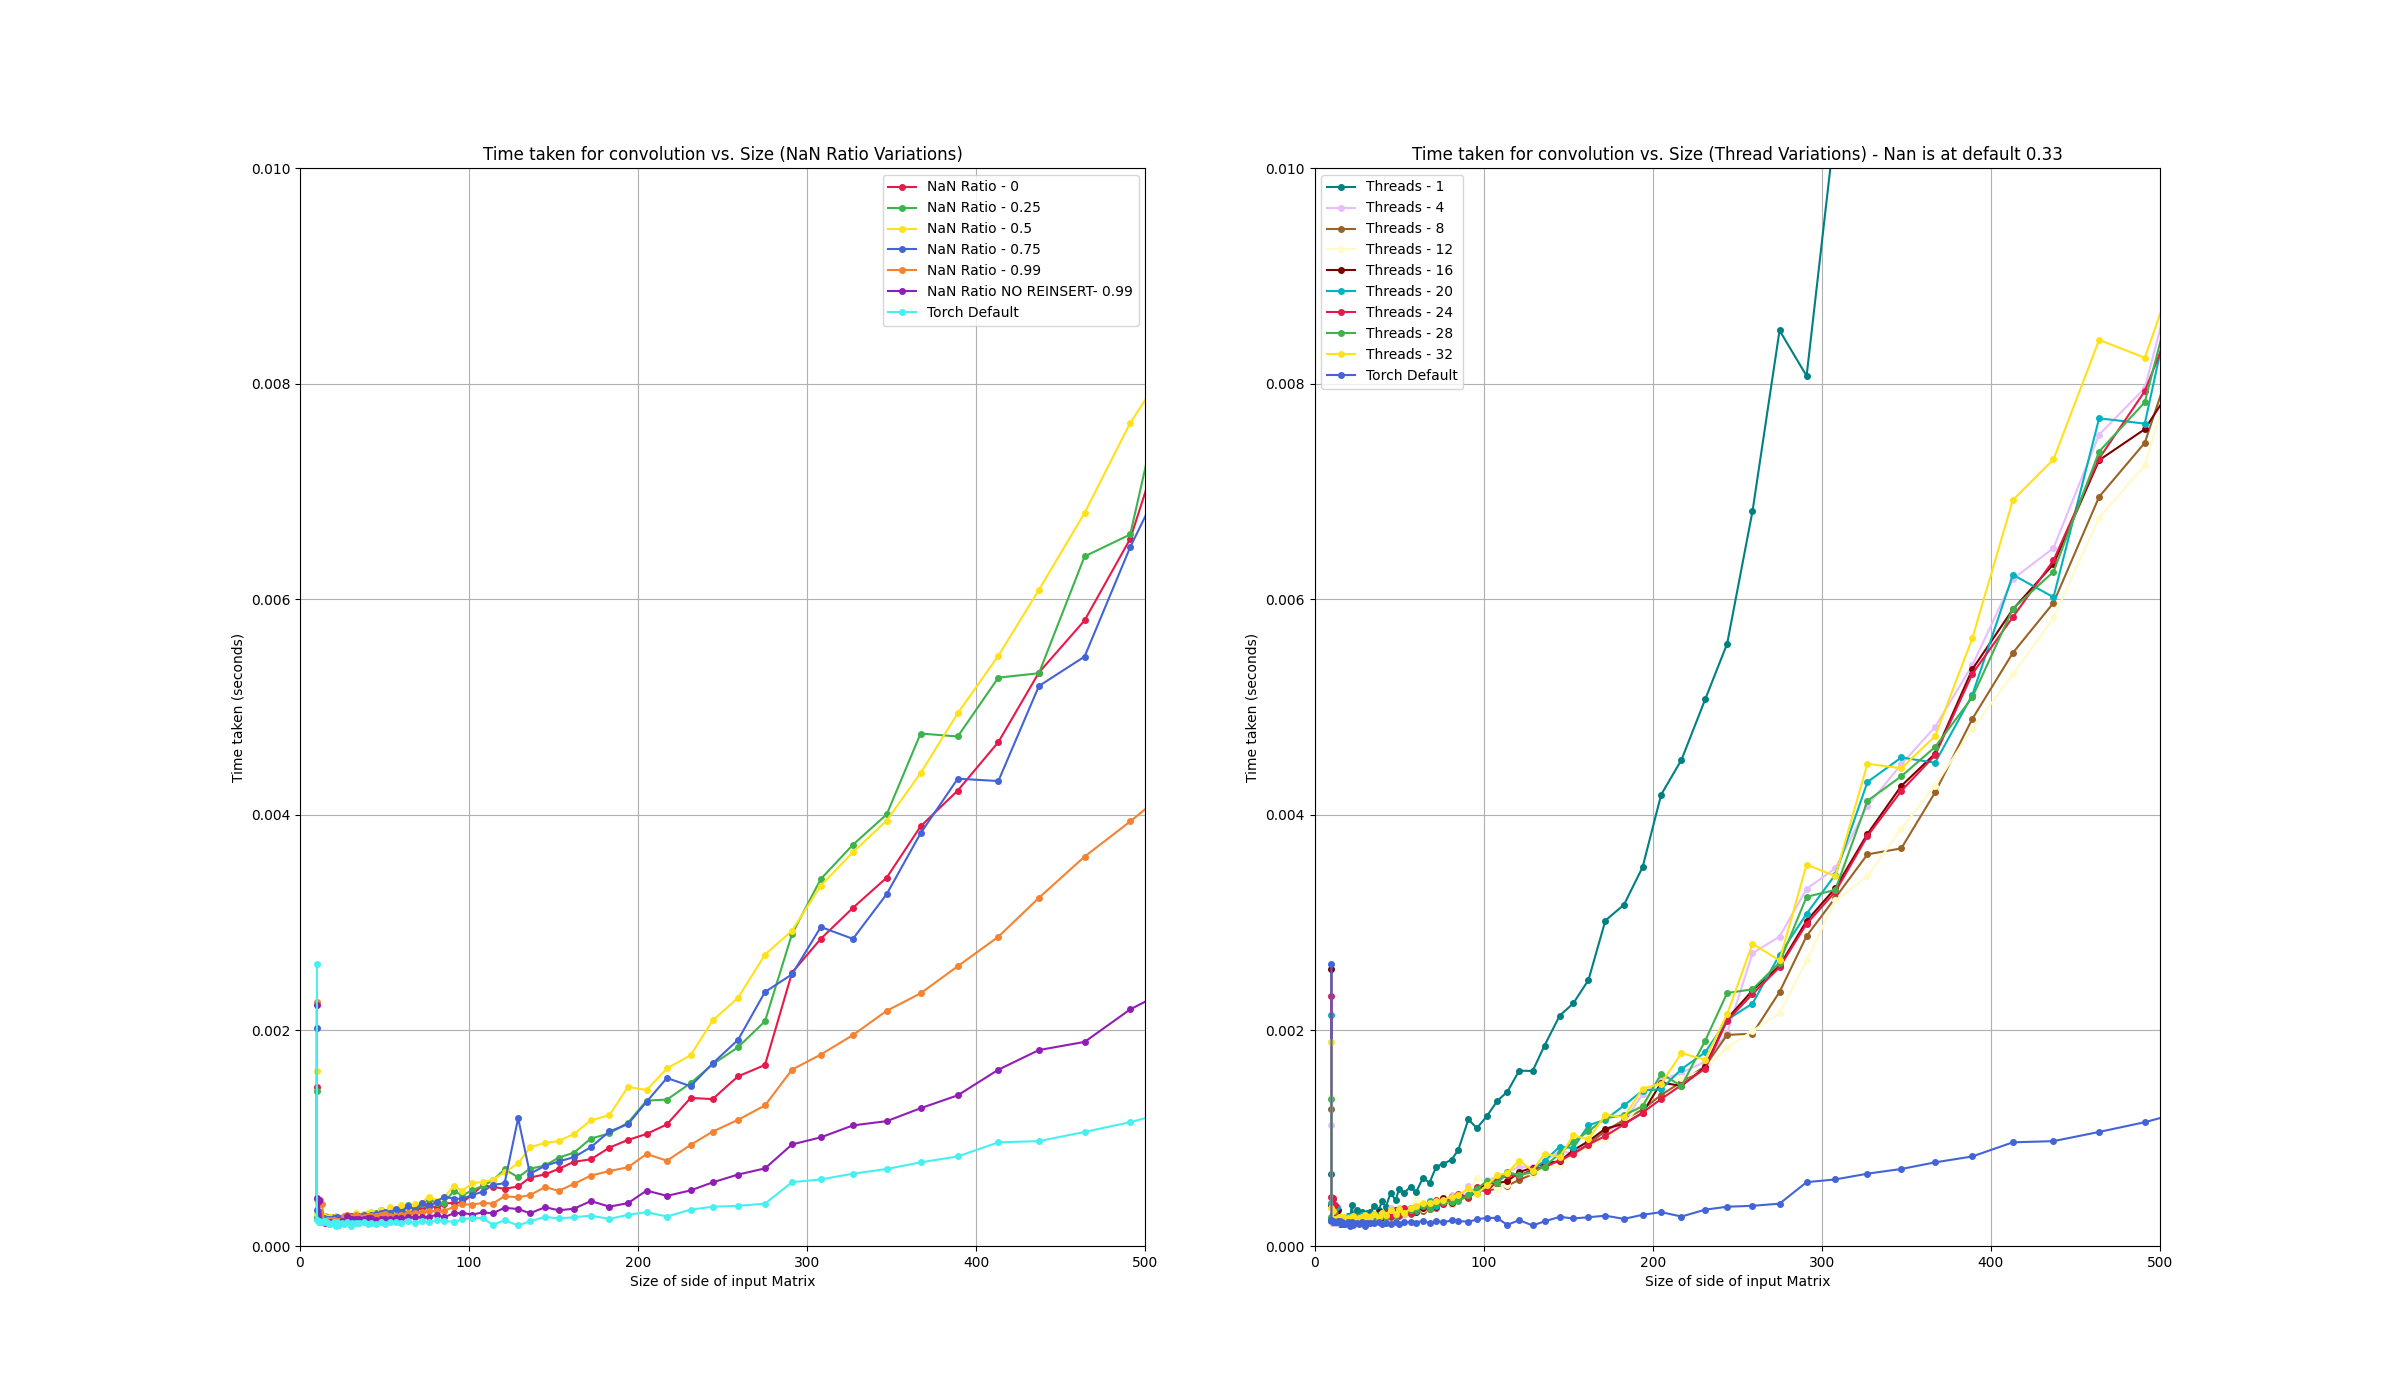

From fastest to slowest left
1. Torch Default (Turquoise)
2. All Nans, no re-insert (Purple)
3. All Nans, re-insert (Orange)
4. 75% Nans (Blue) 
5. No Nans (Red)
6. 25% Nans (Green)
7. 50% Nans (Yellow)

Interestingly, 50% nan is one of the worst performers. This could be because, while you benefit from less multiplication, there is a lot of conditional checking which creates overhead.

For the right plot, a performance wall is hit after ~4 threads.

Unfortunetly, while there is a massive speedup when implementing directly into torch's backend compared to earlier versions using Torch extensions. We are still some way off of beating Torch's native implementation. 


From earlier, see that that in our examples, we use a window size of 4, which represents (```c++ *k```) in our piece of code. Put differently, having more than 4 threads will not help, since our outer loop will not be bigger than this. It would be better to make it more friendly for more threads. 

Hence, we can re-write this piece of code to seperate the threads within the columns, rather than by col as is being done.

Also, to make it go even more quick, the resulting index will be precomputed with a scan (since it cannot be determined what the resulting index is beforehand, and a counter here would need to be shared between threads which would make performance horrible).

```c++
int* new_index = new int[*m];
int new_col_tracker = 0;
for (int i = 0; i < *m; ++i) {
    new_index[i] = !col_to_remove[i] ? new_col_tracker++ : -1;
}

new_m = *m - col_to_remove;
// Allocate memory for the new matrix
float* new_a = new float[new_m * (*k)];

// Write the new matrix in column-major order
#pragma omp parallel for
for (int i = 0; i < *m; ++i) {
    if (new_index[i] != -1) {
    for (int j = 0; j < *k; ++j) {
        // checking if we're inserting NaNs
        new_a[new_index[i] + j * new_m] = std::isnan(a[i + j * (*lda)]) ? 0 : a[i + j * (*lda)];
    }
    }
}
```

The resulting speedups can be seen, note the different y-axis scales.
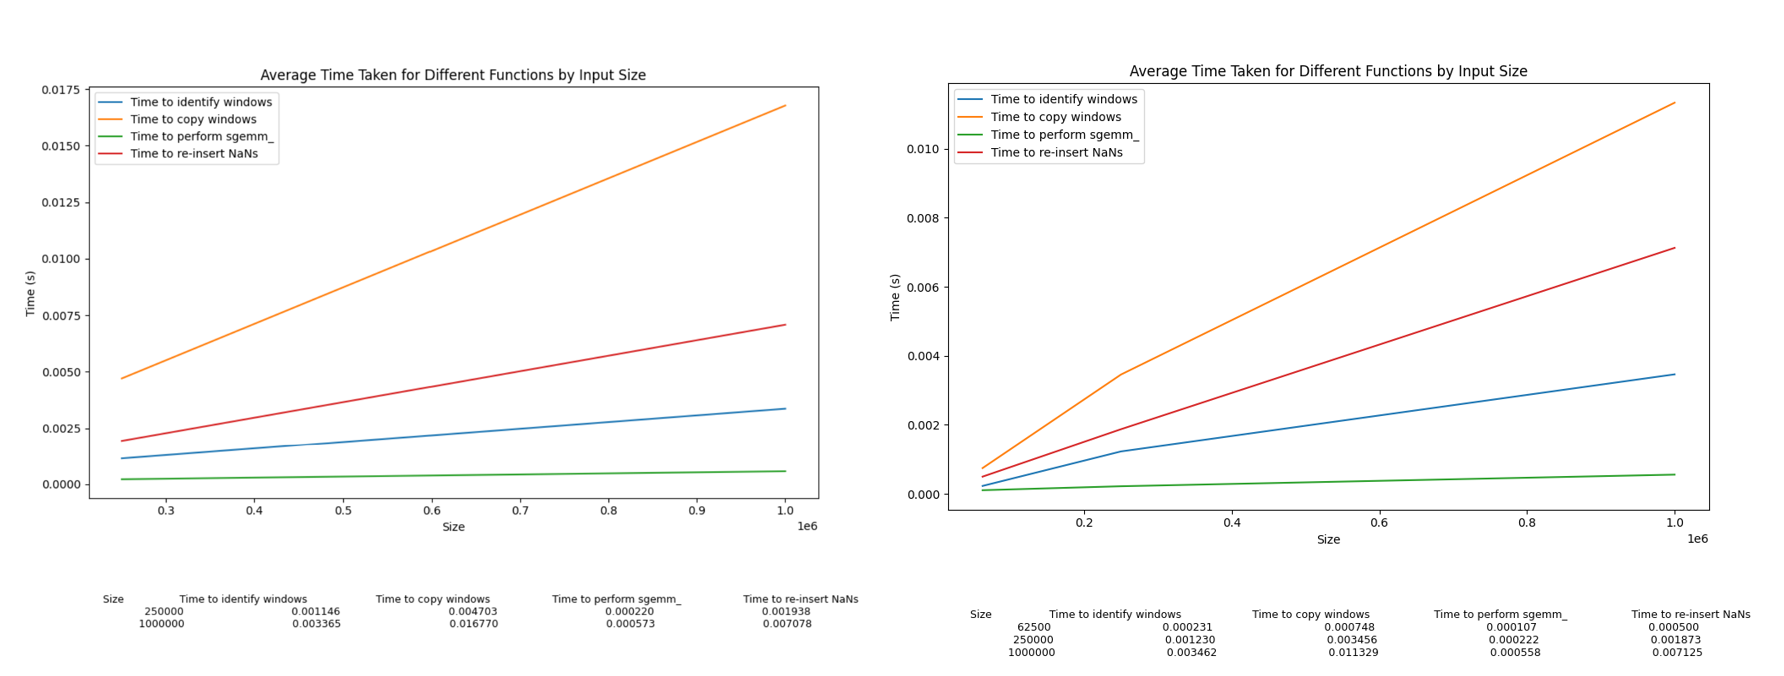

And now, if we plot our previous graphs checking the time taken with respect to size, we obtain the following.
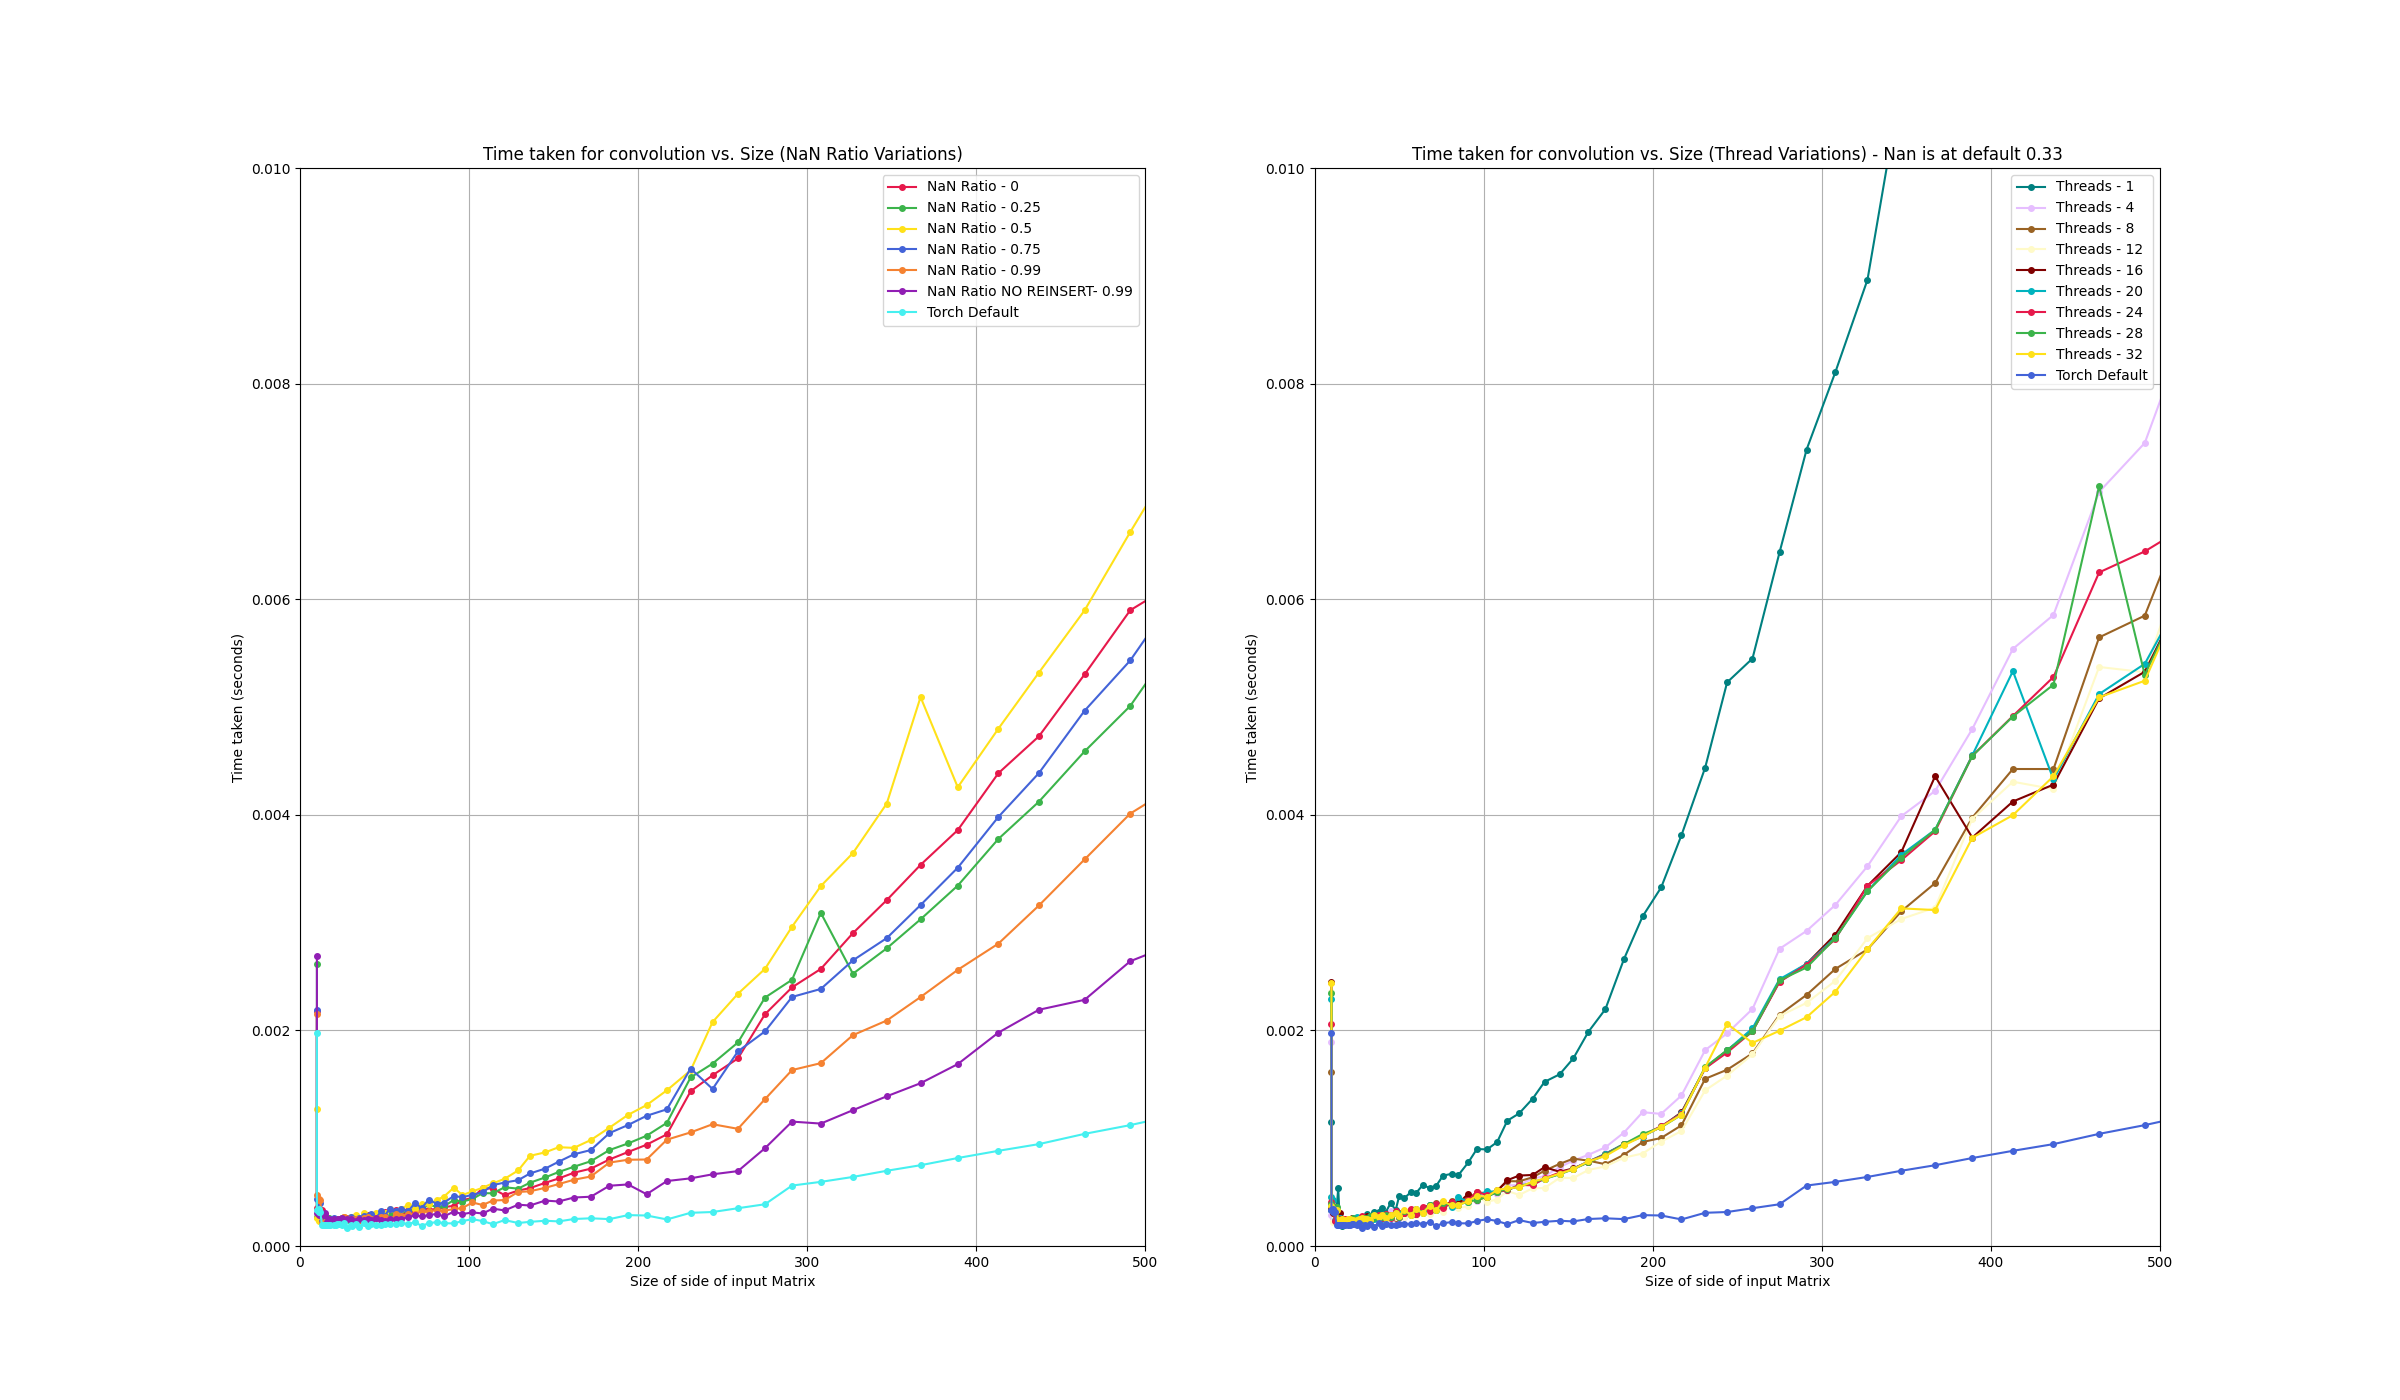

While some go dramatically faster (all NaN ratios excluding an input full of nans) - for instance 50% NaNs went from ~0.008 to ~0.0065, which is an ~19% speedup, and some go a little slower (99% NaN, no re-insert), either almost no speedup or a little slower. The general trend seems to be an improvement in execution times. Likewise, we see that we can nice utilize more than 4 threads, seeing improvement until 20 threads, which was previously capping at 4 threads.

#

## 7.8 Modifying compute_columns and unfolded2d
The next logical choice would be try to check for the nans directly when the windows are extracted, this is done in the compute columns in ```ConvolutionMM2d.cpp```. This in turn, eventually leads to a cpu implementation to extract the im2col representation called ```unfold2d.cpp```. Let's take a look at the structure of this function. The main parts are as follows (most of it was ommitted for clarity):

```c++
static void unfolded2d_copy(
    const scalar_t* input_data,
    scalar_t* finput_data,
    int64_t kH, // Kernel Height size
    int64_t kW, 
    int64_t dH, // Stride Height
    int64_t dW,
    int64_t padH, 
    int64_t padW,
    int64_t n_input_plane, // Channels
    int64_t input_height,
    int64_t input_width,
    int64_t output_height,
    int64_t output_width) {
  at::parallel_for(
      0, (int64_t)n_input_plane * kH * kW, 0, [&](int64_t start, int64_t end) {
        for (const auto k : c10::irange(start, end)) {
          int64_t nip = k / (kH * kW); // input plane index
          int64_t rest = k % (kH * kW);
          int64_t kh = rest / kW; // kernel height index
          int64_t kw = rest % kW; //kernel width index
          int64_t x, y;
          int64_t ix, iy;
          scalar_t* dst = finput_data +
              nip * ((size_t)kH * kW * output_height * output_width) +
              kh * ((size_t)kW * output_height * output_width) +
              kw * ((size_t)output_height * output_width);
          const scalar_t* src =
              input_data + nip * ((size_t)input_height * input_width);
            // Ommited some code to save space
           {
            for (y = 0; y < output_height; y++) {
              iy = (int64_t)y * dH + kh;
              ix = 0 + kw;
              if (dW == 1) {
                  memcpy(
                      dst + (size_t)y * output_width,
                      src + (size_t)iy * input_width + ix,
                      sizeof(scalar_t) * output_width);
              }
              else {
              }
            }
          }
        }
      });
```
Here is a brief breakdown of what is done:

The outer loop iterates over each index of the kernel height and width (so every index of the kernel). Then, in the input, for each row that will contribute to the output (given by the y < output_height), we extract the output width and copy it over. 

Let's look at an example to clarify this. 

Imaging the following matrice (4x4) convolved with a 2x2 kernel of 1's
```
1  2  3  4 
5  6  7  8 
9  10 11 12
13 14 15 16
```
The calculated output size would be 3x3. Hence, we first iterate over all the rows in the input that index (0,0) of the kernel can be found. And, we copy over 3 sequential memory locations. So after our first iterations of possible positions ((0,0), (1,0), (2,0), (NEW KERNEL POSITION) (1,1), (2,1) (3, 1) ... ). We obtain the following (I've added | between inner loop iterations and || for a new outer loop iteration)

1 2 3 | 5 6 7 | 9 10 11 || 2 3 4 | 6 7 8 | 10 11 12 || 5 6 7 | 9 10 11 | 13 14 15 || 6 7 8 | 10 11 12 | 14 15 16. 

If we re-arrange for visualiztion, we observe it gives the im2col transformation. Every column is now a window.

```
1 2 3 | 5  6  7  | 9  10 11
2 3 4 | 6  7  8  | 10 11 12
5 6 7 | 9  10 11 | 13 14 15
6 7 8 | 10 11 12 | 14 15 16
```
This is a highly parallelizable operation and it offers sequential memory copying. However, this doesn't allow us to compute the NaNs during window extraction.

One of the main problems of acting on these windows (after we have them) is that we are operating on non-sequential memory patterns. Think is not optimal for the caching. An idea would then be to re-write these conversion into row major order. 

Here is a pseudo-code:

Alternative method:

For every window row:

&nbsp;For all input columns in output width:

&nbsp;&nbsp;For every input row in input height:
    
&nbsp;&nbsp;&nbsp;&nbsp;memcopy window width over to destinations where it should be found

Window size is 2x2. So convolution would give us an output of 3x3. 
Input:
```
1  2  3  4 
5  6  7  8 
9  10 11 12
13 14 15 16
```
In our case, we would iterate over all kernel row possible positions (so we would start with all rows that can accomodate the top row of the kernel)
  Then, loop over output width (3 columns so 3 iterations):
    Inside that loop, iterate over input height (4 rows so 4 iterations)
    Every time, we will take the window width size and copy it over to its destination (in this case: copy two elements to destination)
    * Some rows will be copied to two different locations

Starting with all rows in input that can accomodate top kernel row

-- Output width interation 1 of 3

Row 1 Iteration (insert 1 2):   1 2 0 0 | 0 0 0 0 | 0 0 0 0 | 0 0 0 0   | 0 0 0  0  | 0 0 0  0  | 0 0  0  0  | 0  0  0  0  | 0  0  0  0

Row 2 Iteration (insert 5 6):   1 2 0 0 | 0 0 0 0 | 0 0 0 0 | 5 6 0 0   | 0 0 0  0  | 0 0 0  0  | 0 0  0  0  | 0  0  0  0  | 0  0  0  0

Row 3 Iteration (insert 9 10):  1 2 0 0 | 0 0 0 0 | 0 0 0 0 | 5 6 0 0   | 0 0 0  0  | 0 0 0  0  | 9 10 0  0  | 0  0  0  0  | 0  0  0  0

-- Output width interation 2 of 3

Row 1 Iteration (insert 2 3):   1 2 0 0 | 2 3 0 0 | 0 0 0 0 | 5 6 0 0  | 0 0 0  0  | 0 0 0  0  | 9 10 0  0  | 0   0   0   0  | 0  0  0  0

Row 2 Iteration (insert 6 7):   1 2 0 0 | 2 3 0 0 | 0 0 0 0 | 5 6 0 0  | 6 7 0  0  | 0 0 0  0  | 9 10 0  0  | 0   0   0   0  | 0  0  0  0

Row 3 Iteration (insert 10 11): 1 2 0 0 | 2 3 0 0 | 0 0 0 0 | 5 6 0 0  | 6 7 0  0  | 0 0 0  0  | 9 10 0  0  | 10  11  0   0  | 0  0  0  0


-- Output width interation 3 of 3

Row 1 Iteration (insert 3 4):   1 2 0 0 | 2 3 0 0 | 3 4 0 0 | 5 6 0 0  | 6 7 0  0  | 0 0 0  0  | 9 10 0  0  | 10  11  0   0  | 0  0  0  0

Row 2 Iteration (insert 7 8):   1 2 0 0 | 2 3 0 0 | 3 4 0 0 | 5 6 0 0  | 6 7 0  0  | 7 8 0  0  | 9 10 0  0  | 10  11  0   0  | 0  0  0  0

Row 3 Iteration (insert 11 12): 1 2 0 0 | 2 3 0 0 | 3 4 0 0 | 5 6 0 0  | 6 7 0  0  | 7 8 0  0  | 9 10 0  0  | 10  11  0   0  | 11  12  0  0


Now, we would repeat with all rows in the input matrix that can accomodate the bottom row. Eventually, this results in memory of

1 2 5 6 | 2 3 6 7 | 3 4 7 8 | 5 6 9 10 | 6 7 10 11 | 7 8 11 12 | 9 10 13 14 | 10 11 14 15 | 11 12 15 16

Under a differnt view this is 
```
1  2  5  6 
2  3  6  7 
3  4  7  8 
5  6  9  10
6  7  10 11
7  8  11 12
9  10 13 14
10 11 14 15
11 12 15 16
```
This would involve changing another function in torch's backend. Let's take a look like this: 


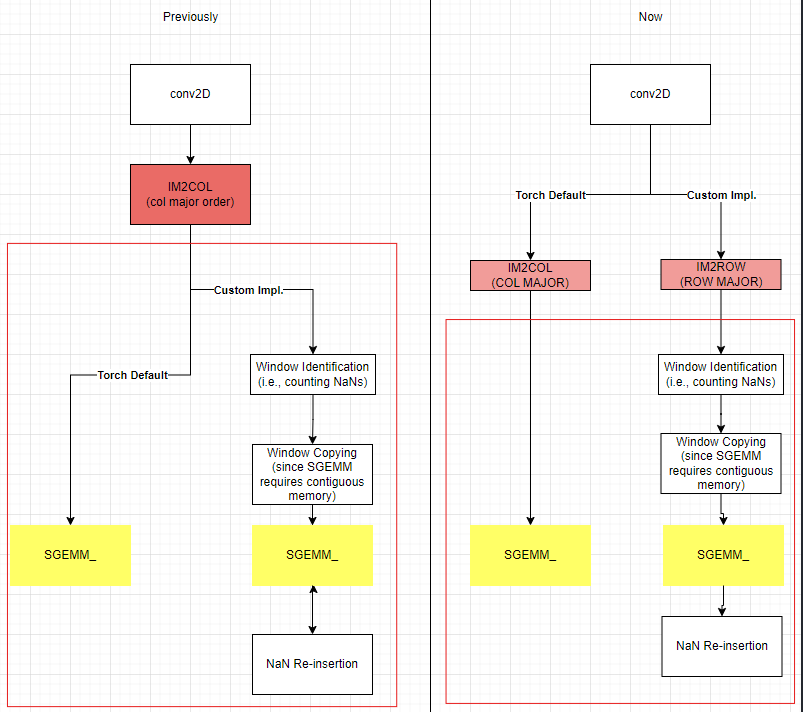

Previously, we only changed the order of function calls, adding two before SGEMM, and one after. However, now, we change the conversion as well. If all goes to plan, the three functions (window identifications, window copying and nan-re-insertion, should be quicker).

Here is the new conversion code:

```c++
int offset = 0;
      for (int rowsKernel = 0; rowsKernel < kH; rowsKernel++) { //start at first row since row one started above
        for (int ip = 0; ip < n_input_plane; ip++) { // looping through channels
          #pragma omp parallel for private (src, dest) collapse(2)
          for (int ow = 0; ow < output_width; ow++) {
            for(int oh = 0; oh < input_height; oh++) {
              // Checking if current row in input can be a top row of a window
              // e.g., with a 2x2 kernel, the bottom row cannot be the top row of a window
              if (oh - rowsKernel >= output_height) {
                continue;
              } 
              // Checking it current row in input can be a bottom row of a window, should
              // fail for the first row
              else if (oh - rowsKernel < 0) { 
                continue;
              }
              offset = rowsKernel*(output_width*kH*kW - kW); //every row needs to be offset to the left
              src = 
                input_data + ip * input_height * input_width + oh * input_width + ow;
              dest = 
                (finput_data + 
                ip * kH * kW * output_height * output_width + // not sure if channels work
                ow * kH*kH + oh * kH * kW * output_width - offset);
              memcpy(dest, src, kW * sizeof(scalar_t));
            }
          }
        }
      }
```

> Note: We are only evaluating the impact of different memory formats. So, the difference in time taken to perform the actual computation of extracting the windows using IM2ROW or IM2COL is ignored. Only the steps that come **AFTER** are taken into consideration. If you want to see

As is seen in the previous graph, we want to look at if the re-ordering of the memory would have an impact of the operations specific to NaNs. When doing so, we have a baseline (Torch default), and two different implementations regarding the treatment of nans. Both operate following the same logic, but on different memory formats.

To see if the impact of re-writing the this memory has an impact, we first calculate the time taken to run torch default **without** regards to NaNs, and assume SGEMM_'s speed as the time to beat. This is referred to as Torch Default. 

Then, we run our first solution to deal with NaNs (but acting on a column major format - as is the default in Torch). We then record the time taken to run the operations to deal with the NaNs, **as well as** SGEMM_. This is referred to as COLMAJOR. Then, we repeat our NaN operations but in rowmajor order. The three times are then compared. 



Table 1: Time Taken for different steps of NaN conv for rowmajor, column major and torch default for a 500x500 convolution with 33% NaNs. 
Time given in seconds. Speedup factor comparing COLMAJOR and ROWMAJOR on the last row.

Label Explanation:
- NaN Counting: Count the nans per window
- Memory re-arranging: Re-copy only the kept windows into memory
- SGEMM: Multiplication
- NaN re-insertion: Re-insert nans for removed rows


| Type                         | NaN Counting | Memory re-arranging | SGEMM       | Speedup factor for SGEMM | NAN RE-INSERTION | Total       | Speedup factor for total |
|------------------------------|-----------------------|----------------|-------------|--------------------------|------------------|-------------| --------------------------|
| DEFAULT                      | 0                     | 0              | 0.000243102 | 1                        | 0                | 0.000243102 | 1                        |
| COLMAJOR                       | 0.000980643           | 0.003309536    | 0.000214367 | 1.134045819              | 0.001911062      | 0.006415608 | 0.037892278              |
| ROWMAJOR                       | 0.000887494           | 0.002964344    | 0.000352871 | 0.688925981              | 0.002001671      | 0.00620638  | 0.039169693              |
| Speedup Factor of ROWMAJOR  | 1.104957329           | 1.116448024    | 0.607493957 | /                        | 0.95473332       | 1.033711761 | /                        |


Hence, we can see that our custom segments are quicker (identification, core-arranging) or almost the same (re-insertion), but at the costs of slowing SGEMM. Our changes thus almost cancel out.
It can also be noticed that the effect of having 30% nans makes it a bit quicker for IM2COL, but not for IM2ROW. This can maybe be because the tranposed matrix is slower to multiply. 

Visually, these like this:

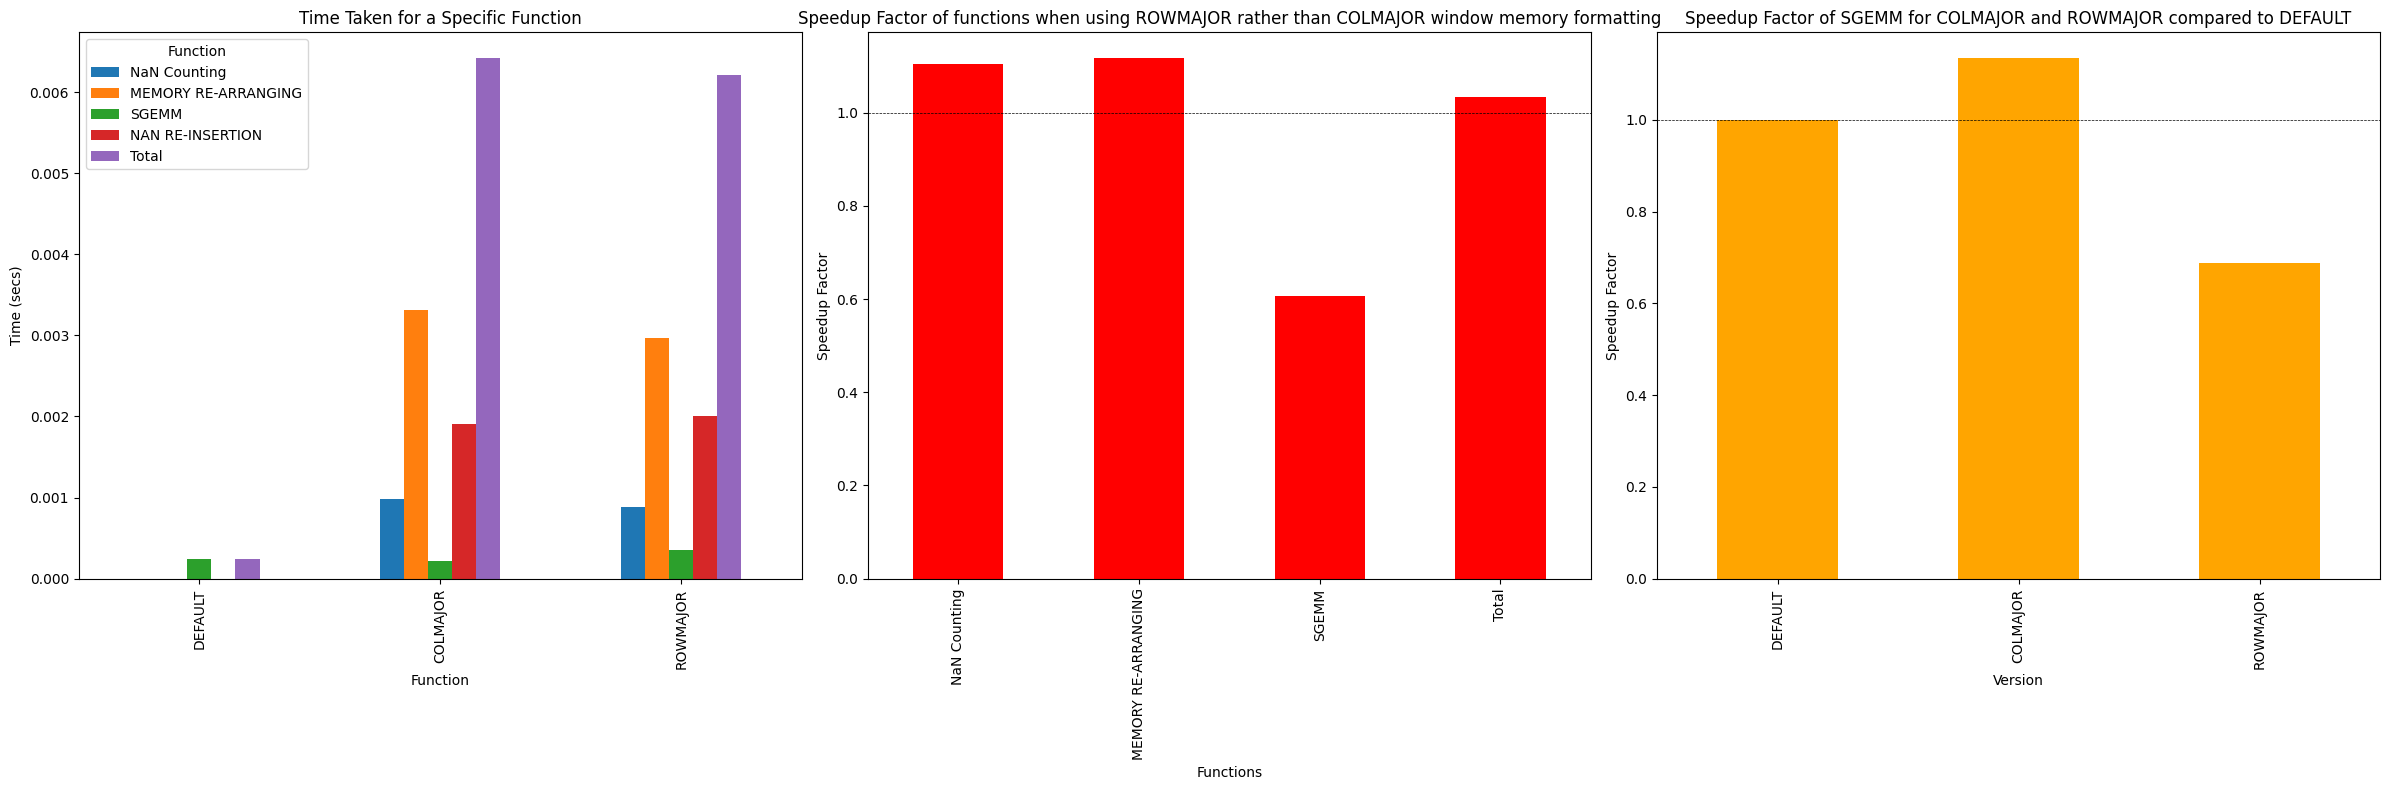


For informational purposes only, the image below is the effect of changing to row column on convolution time, my implementation does not parallelize well. This may be because I use nested loops whereas torch seems to combine multiple loops into one. 

Eg., instead of have an outer loop from 0 - 9, and an inner one from 0 - 9. They would have one loop from 0-81. 

Right now, I have not worked on making it faster, since what comes after is already slower (the nan computations), so unless we have a good reason to work on it, it will remain like this.

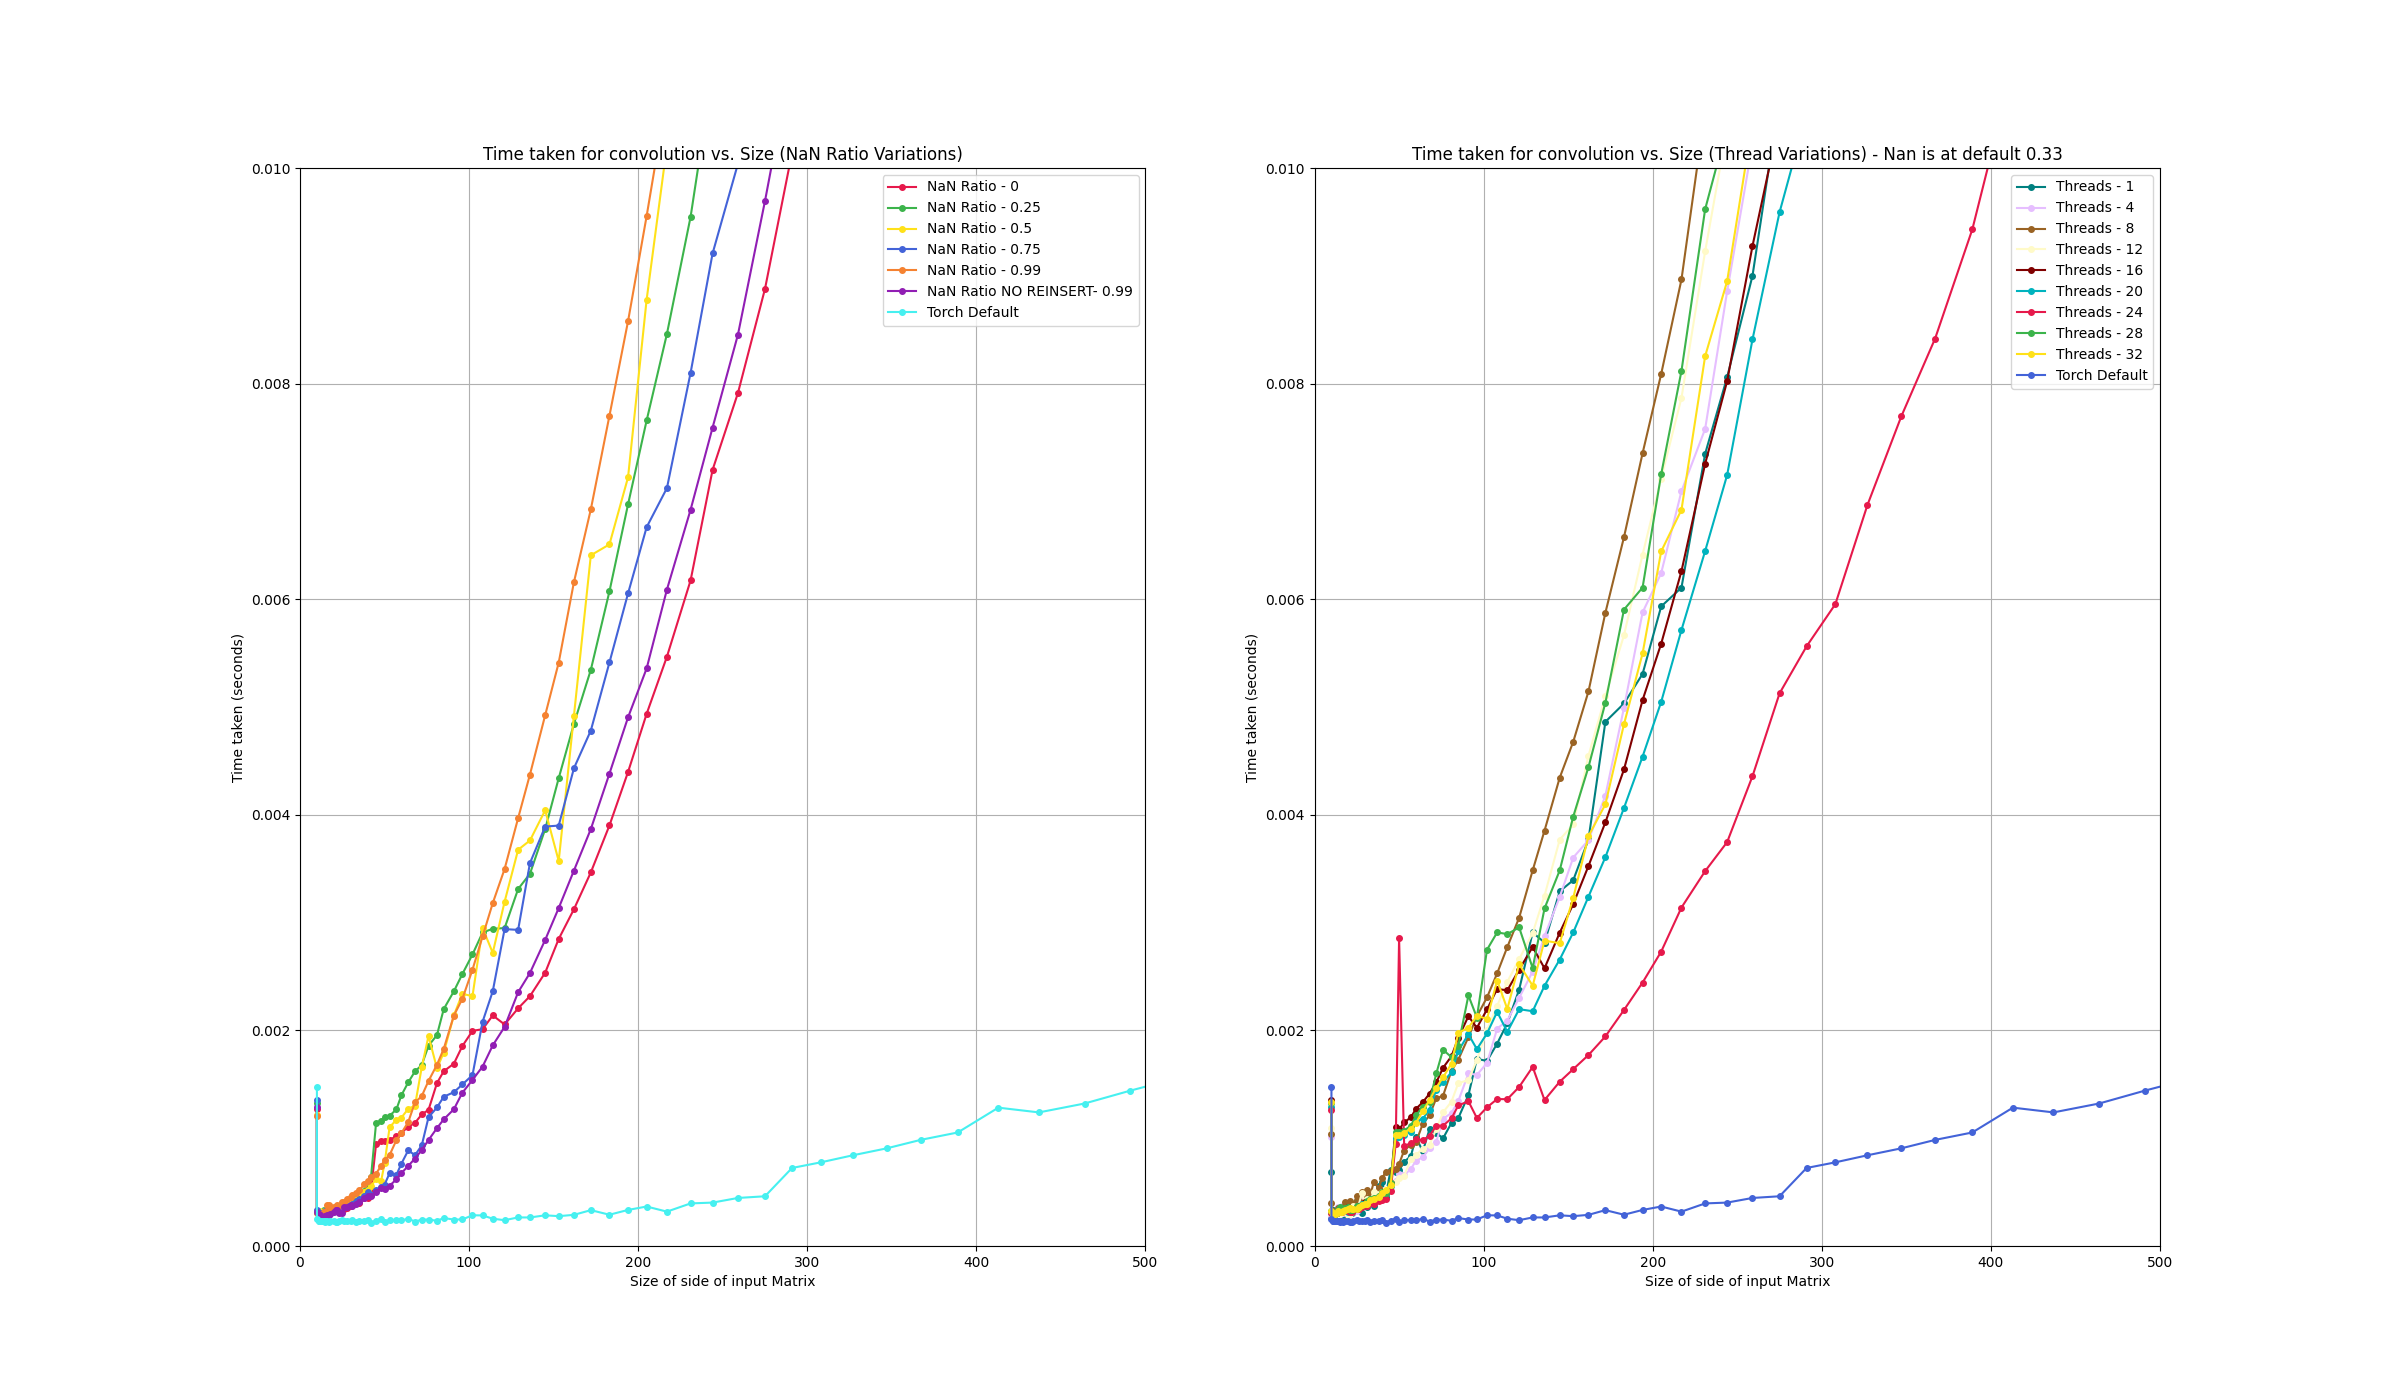

For a 500x500, the actual computation of im2col vs im2row (i.e., extracting windows in columns vs rows), 32 threads:

IM2COL: 0.000690919 seconds

IM2ROW: 0.025405 seconds


Speedup = 0.027

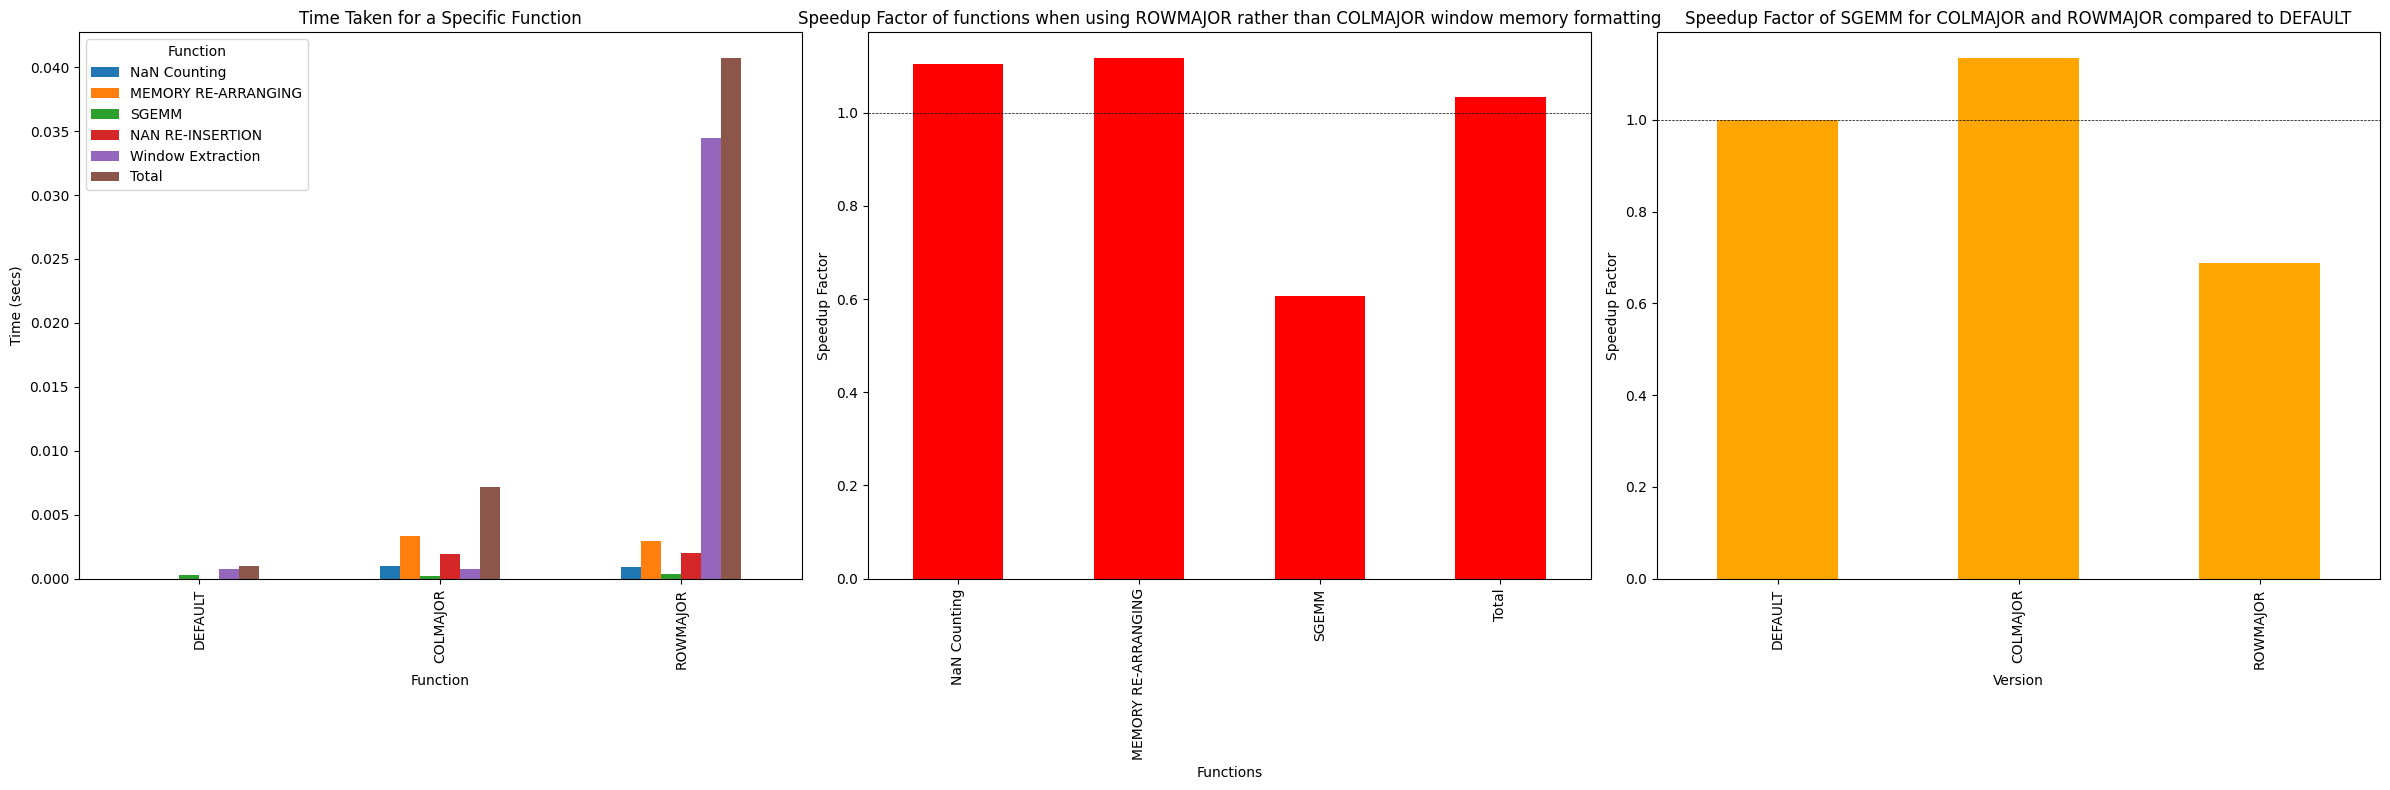


Label Explanation:
- NaN Counting: Count the nans per window
- Memory re-arranging: Re-copy only the kept windows into memory
- SGEMM: Multiplication
- NaN re-insertion: Re-insert nans for removed rows
- Window extraction: Either im2col or im2row (just coverting the input into windows)

### 7.9 Continuing goals decisions

Given there were no increase in speed for im2row, it was decided going forward to go back to the quickest model we had when considering parallelization. As such, going forward, im2col with NaN treatment was going to be used.

## 8.0 Extrapolating for batches

Now, all the code previously was tested extensively for channels + row + col, but not for batches (either for kernel or input data). This was because we wanted a rough speed benchmark to see if a speedup was observed. However, now, after testing for accuracy we need to make sure everything works.
Hence, it will need to be adjusted accordingly.

Some small tweaks were made here and there afterwards (e.g, changing the 0 for a mean of the window, adding env variables), and some bugs were fixed. The final version looks like this:

## 8.1 Final Version [CURRENTLY USED]

```c++
void preprocessing(
    char* transa, char* transb, int* m, int* n, int* k, 
    float* alpha, const float* a, int* lda, const float* b, int* ldb, 
    float* beta, float* c, int* ldc) 
{
    float nan_threshold = 0.50;
    char* env_threshold = std::getenv("THRESHOLD");
    if (env_threshold != NULL){
      nan_threshold = std::stof(env_threshold);
    }
    bool* col_to_remove = new bool[*m];
    double* col_mean = new double[*m];
    int cols_removed = 0;
    int nan_count = 0;
    int new_m = *m;
    int sum = 0;
    #pragma omp parallel for reduction(+:cols_removed) private (nan_count, sum)
    for (int i = 0; i < *m; ++i) {
      sum = 0;
      nan_count = 0;
      col_to_remove[i] = false;
      // std::cout << "Checking window: " << i << ", Elements: ";
      for (int j = 0; j < *k; ++j) { // k is num elements in the window
        sum += std::isnan(a[j * (*lda) + i]) ? 0: a[j * (*lda) + i];
        if (std::isnan(a[j * (*lda) + i])) {
            nan_count++;
            if (nan_count > (nan_threshold * static_cast<float>(*k))) {
                col_to_remove[i] = true;
                cols_removed++;
                break;
            }
        }
      }
      col_mean[i] = sum / (*k - nan_count);
    }
    int* new_index = new int[*m];
    int new_col_tracker = 0;
    for (int i = 0; i < *m; ++i) {
      new_index[i] = !col_to_remove[i] ? new_col_tracker++ : -1;
    }
   
    new_m = *m - (cols_removed);
    // Allocate memory for the new matrix
    float* new_a = new float[new_m * (*k)];

    // Write the new matrix in column-major order
    #pragma omp parallel for
    for (int i = 0; i < *m; ++i) {
      if (new_index[i] != -1) {
        for (int j = 0; j < *k; ++j) {
          // checking if we're inserting NaNs
          new_a[new_index[i] + j * new_m] = std::isnan(a[i + j * (*lda)]) ? col_mean[i] : a[i + j * (*lda)];
        }
      }
    }
    a = new_a;
    *m = new_m;
    *lda = new_m;

    //Calling sgemm_
    int skipped = 0;
    if (*m == 0 || *lda == 0){
      skipped = 1;
    }
    
    if (skipped == 0){
      sgemm_(
          transa, transb,
          m, n, k,
          alpha,
          a, lda,
          b, ldb,
          beta,
          c, ldc);
    }
    /*
    Method 1: Right-to left in-place NaN insertions.
    To do so, we will keep two pointers in Matrix C and iterate from right to left. The first pointer will point to index c + *lda * *n - 1. 
    The second will point to C + *ldc * *n - 1. Recall, lda < ldc since we adjust lda earlier. 
    If the value in the row is NaN, we will insert NaNs at the second pointer. Else, we will
    insert at the second pointer, the value pointed by the first pointer. 
    Best Case: 1 copy, O(n) time complexity
    Worst Case: 1 full copy, O(n) time complexity
    */
    float* c_ptr = nullptr;
    float* c_ptrLDA = nullptr;

    int flag = 1; // defaults to running
    char* env_reinsert = std::getenv("REINSERT");
    if (env_reinsert != NULL){
      flag = std::stoi(env_reinsert); //if we pass 0 it won't run
    }
    int offset = 0;
    if (flag == 1){
      #pragma omp parallel for private(offset, c_ptr, c_ptrLDA)
      for (int cur_n = *n; cur_n > 0; --cur_n){
        offset = (cur_n - 1) * (*ldc);
        // Pointer 1: End of matrix C
        c_ptr = c + ((*ldc) - 1 + offset);
        // Pointer 2: At index *lda - 1, which is the end of what sgemm returns
        c_ptrLDA = c + (*lda - 1 + offset);
        for (int i = (*ldc) - 1; i >= 0; --i){
          if (col_to_remove[i%(*ldc)]){
            *c_ptr = std::numeric_limits<float>::quiet_NaN();
          } else {
            *c_ptr = *c_ptrLDA;
            c_ptrLDA--;
          }
          c_ptr--;
        }
      }
    }
    
    delete[] new_a;
    delete[] new_index;
    delete[] col_to_remove;
}
```
The indexing was ajusted accordingly for the different batches being called. As an important note, n is sgemm refers to the number of batches inside the kernels. For multiple batches in the input, its simply a bunch of individual calls to sgemm.

This passed all unit tests that were created for testing the implementation.

# Conclusion
In this project, the primary goal was to observe a speedup in the convolutional layers. However, it was discovered that the naive implementation of convolutions was not what was really used in torch's backend. Instead, im2col version was what was being used. In an attempt to try to observe a speedup, the backend was modified to incorporate treatment of NaNs within the torch stack. This process itself was successful, all unit tests were passing. However, no speedup was observed - this is because the added overhead of copying the memory could not be beaten by simply reduing the number of multiplications during im2col.



## Works Cited:

[1] Alzubaidi, L., Zhang, J., Humaidi, A.J. et al. Review of deep learning: concepts, CNN architectures, challenges, applications, future directions. J Big Data 8, 53 (2021). https://doi.org/10.1186/s40537-021-00444-8

[2] Zhao, L., Zhang, Z. A improved pooling method for convolutional neural networks. Sci Rep 14, 1589 (2024). https://doi.org/10.1038/s41598-024-51258-6

[3] “image processing - Computational Complexity of 2D Convolution,” Computational Science Stack Exchange. https://scicomp.stackexchange.com/questions/10356/computational-complexity-of-2d-convolution